In [2]:
# Import all the necessary modules
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas_datareader as pdr
import math
import datetime
import itertools
import yfinance as yf
import seaborn as sn
from IPython.display import display, HTML
from trend_following import (apply_jupyter_fullscreen_css, load_financial_data, get_returns_volatility, calculate_slope, trend_signal, slope_signal, 
                             create_trend_strategy, get_close_prices, calculate_donchian_channels)
from strategy_performance_metrics import (calculate_sharpe_ratio, calculate_calmar_ratio, calculate_CAGR, calculate_risk_and_performance_metrics,
                                          calculate_compounded_cumulative_returns, estimate_fee_per_trade, rolling_sharpe_ratio)
import coinbase_utils as cn
import strategy_performance_metrics as perf
import trend_following as tf
%matplotlib inline

In [3]:
import importlib
importlib.reload(cn)
importlib.reload(perf)
importlib.reload(tf)

<module 'trend_following' from '/Users/adheerchauhan/Documents/git/trend_following/trend_following.py'>

In [4]:
import warnings
warnings.filterwarnings('ignore')
pd.set_option('Display.max_rows', None)
pd.set_option('Display.max_columns',None)
apply_jupyter_fullscreen_css()

## Helper functions to help pull the data and run the analysis

### Moving Average and Donchian Channels Signals

In [10]:
from strategy_performance_metrics import calculate_risk_and_performance_metrics

import seaborn as sns

def plot_moving_avg_crossover_performance(df_performance, ticker):
    unique_step_sizes = df_performance['stepsize'].unique()

    # Plotting each heatmap in a loop
    for step in unique_step_sizes:
        subset = df_performance[df_performance['stepsize'] == step]
        pivoted_df_sharpe = subset.pivot(index='slow_mavg', columns='fast_mavg', values='sharpe_ratio')
        pivoted_df_calmar = subset.pivot(index='slow_mavg', columns='fast_mavg', values='calmar_ratio')
        pivoted_df_return = subset.pivot(index='slow_mavg', columns='fast_mavg', values='annualized_return')
        
        fig = plt.figure(figsize=(30,6))
        # plt.style.use('bmh')
        layout = (1,3)
        sharpe_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
        calmar_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
        return_ax = plt.subplot2grid(layout, (0,2))#, colspan=2)

        sns.heatmap(pivoted_df_sharpe, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=sharpe_ax)
        _ = sharpe_ax.set_title(f'{ticker} Sharpe Ratio Heatmap\nStep Size: {step}')
        _ = sharpe_ax.set_ylabel('Slow Moving Average (Days)')
        _ = sharpe_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_calmar, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=calmar_ax)
        _ = calmar_ax.set_title(f'{ticker} Calmar Ratio Heatmap\nStep Size: {step}')
        _ = calmar_ax.set_ylabel('Slow Moving Average (Days)')
        _ = calmar_ax.set_xlabel('Fast Moving Average (Days)')

        sns.heatmap(pivoted_df_return, annot=True, fmt=".2f", cmap='RdYlGn', linewidths=.5, ax=return_ax)
        _ = return_ax.set_title(f'{ticker} Annualized Return Heatmap\nStep Size: {step}')
        _ = return_ax.set_ylabel('Slow Moving Average (Days)')
        _ = return_ax.set_xlabel('Fast Moving Average (Days)')

        plt.tight_layout()
    
    return

def generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    # Generate Trend Signal
    if use_coinbase_data:
        df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = (df[['close']].rename(columns={'close':ticker}))
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
    else:
        df = tf.get_close_prices(start_date, end_date, ticker, print_status=False)
    df_trend = (tf.create_trend_strategy(df, ticker, mavg_start=fast_mavg, mavg_end=slow_mavg, mavg_stepsize=mavg_stepsize, slope_window=10, moving_avg_type=moving_avg_type,
                                      price_or_returns_calc=price_or_returns_calc)
                .rename(columns={f'{ticker}_trend_strategy_returns': f'{ticker}_trend_strategy_returns_{fast_mavg}_{mavg_stepsize}_{slow_mavg}',
                                 f'{ticker}_trend_strategy_trades': f'{ticker}_trend_strategy_trades_{fast_mavg}_{mavg_stepsize}_{slow_mavg}'}))
    # Generate Donchian Signal
    df_donchian = tf.calculate_donchian_channels(start_date=start_date, end_date=end_date, ticker=ticker, price_or_returns_calc=price_or_returns_calc,
                                            rolling_donchian_window=rolling_donchian_window, use_coinbase_data=use_coinbase_data)
    if price_or_returns_calc == 'price':

        # Buy signal: Price crosses above upper band
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'close'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_price']), 1,
            np.where((df_donchian[f'close'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_price']), -1, 0))
    elif price_or_returns_calc == 'returns':
        df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_signal'] = np.where(
            (df_donchian[f'{ticker}_pct_returns'] > df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_returns']), 1,
            np.where((df_donchian[f'{ticker}_pct_returns'] < df_donchian[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_returns']), -1, 0))

    # Merging the Trend and donchian Dataframes
    donchian_cols = [f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}',
                     f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}', f'{ticker}_{rolling_donchian_window}_donchian_signal']
    df_trend = pd.merge(df_trend, df_donchian[donchian_cols], left_index=True, right_index=True, how='left')
    
    if include_signal_strength:
        # Calculate the strength of moving average crossover and donchian signal
        df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'] = (df_trend[f'{ticker}_{rolling_donchian_window}_donchian_upper_band_{price_or_returns_calc}'] -
                                                                             df_trend[f'{ticker}_{rolling_donchian_window}_donchian_lower_band_{price_or_returns_calc}'])
        donchian_strength = (np.abs(df_trend[f'{ticker}'] - df_trend[f'{ticker}_{rolling_donchian_window}_donchian_middle_band_{price_or_returns_calc}']) /
                             df_trend[f'{ticker}_donchian_band_width_{price_or_returns_calc}'])
        crossover_strength = np.abs(df_trend[f'{ticker}_{fast_mavg}_mavg'] - df_trend[f'{ticker}_{slow_mavg}_mavg']) / df_trend[f'{ticker}']

        df_trend[f'{ticker}_crossover_donchian_signal_strength'] = (donchian_strength + crossover_strength) / 2
        strength_threshold = 0.5
    
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1) &
                      (df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1) &
                       ((df_trend[f'{ticker}_crossover_donchian_signal_strength'] > strength_threshold)))
    else:
        # Moving Average and Donchian Channel Signal
        buy_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == 1) &
                      (df_trend[f'{ticker}_trend_signal'] == 1))
        sell_signal = ((df_trend[f'{ticker}_{rolling_donchian_window}_donchian_signal'] == -1) &
                       (df_trend[f'{ticker}_trend_signal'] == -1))
    
    if long_only:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, 0))
    else:
        df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'] = (
            np.where(buy_signal, 1, np.where(sell_signal, -1, 0)))
        
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')] * 
        df_trend[f'{ticker}_pct_returns'])
    df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'] = (
        df_trend[(f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal')].diff())
    
    return df_trend

def moving_avg_crossover_with_donchian_strategy_performance(start_date, end_date, ticker, moving_avg_type='exponential', price_or_returns_calc='returns',
                                                           rolling_donchian_window=20, include_signal_strength=True, long_only=False, use_coinbase_data=True):
    
    perf_cols = ['ticker', 'fast_mavg', 'slow_mavg', 'stepsize', 'annualized_return', 'sharpe_ratio', 'calmar_ratio', 'annualized_std_dev', 'max_drawdown', 'max_drawdown_duration',
                'hit_rate', 't_statistic', 'p_value', 'trade_count']
    df_performance = pd.DataFrame(columns=perf_cols)
    
    fast_mavg_list = np.arange(10, 101, 10)
    slow_mavg_list = np.arange(50, 501, 50)
    mavg_stepsize_list = [2, 4, 6, 8]
    performance_rows = []
    for slow_mavg in slow_mavg_list:
        for fast_mavg in fast_mavg_list:
            for mavg_stepsize in mavg_stepsize_list:
                if fast_mavg < slow_mavg:
                    df_trend = generate_trend_signal_with_donchian_channel(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, moving_avg_type, price_or_returns_calc,
                                                                         rolling_donchian_window, include_signal_strength, long_only, use_coinbase_data)
                    performance_metrics = calculate_risk_and_performance_metrics(
                        df_trend, strategy_daily_return_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',
                        strategy_trade_count_col=f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                        annual_trading_days=365, transaction_cost_est=0.005)
                    performance_rows.append({
                        'ticker': ticker,
                        'fast_mavg': fast_mavg,
                        'slow_mavg': slow_mavg,
                        'stepsize': mavg_stepsize,
                        'annualized_return': performance_metrics['annualized_return'],
                        'sharpe_ratio': performance_metrics['annualized_sharpe_ratio'],
                        'calmar_ratio': performance_metrics['calmar_ratio'],
                        'annualized_std_dev': performance_metrics['annualized_std_dev'],
                        'max_drawdown': performance_metrics['max_drawdown'],
                        'max_drawdown_duration': performance_metrics['max_drawdown_duration'],
                        'hit_rate': performance_metrics['hit_rate'],
                        't_statistic': performance_metrics['t_statistic'],
                        'p_value': performance_metrics['p_value'],
                        'trade_count': performance_metrics['trade_count']
                    })
                    # df_performance = df_performance.append(row, ignore_index=True)
    # Convert the list of rows to a DataFrame
    df_performance = pd.DataFrame(performance_rows, columns=perf_cols)
    
    plot_moving_avg_crossover_performance(df_performance, ticker)
    
    return df_performance

In [12]:
def calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc='price', rolling_atr_window=20,
                                 use_coinbase_data=True):
    if use_coinbase_data:
        # df = cn.get_coinbase_ohlc_data(ticker=ticker)
        df = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=end_date, save_to_file=False)
        df = df[(df.index.get_level_values('date') >= start_date) & (df.index.get_level_values('date') <= end_date)]
        df.columns = [f'{ticker}_{x}' for x in df.columns]
    else:
        df = load_financial_data(start_date, end_date, ticker, print_status=False)  # .shift(1)
        df.columns = [f'{ticker}_open', f'{ticker}_high', f'{ticker}_low', f'{ticker}_close', f'{ticker}_adjclose', f'{ticker}_volume']

    if price_or_returns_calc == 'price':
        # Calculate the Exponential Moving Average (EMA)
        # df[f'{ticker}_{rolling_atr_window}_ema_price'] = df['close'].ewm(span=rolling_atr_window,
        #                                                                  adjust=False).mean()

        # Calculate the True Range (TR) and Average True Range (ATR)
        df[f'{ticker}_high-low'] = df[f'{ticker}_high'] - df[f'{ticker}_low']
        df[f'{ticker}_high-close'] = np.abs(df[f'{ticker}_high'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_low-close'] = np.abs(df[f'{ticker}_low'] - df[f'{ticker}_close'].shift(1))
        df[f'{ticker}_true_range_price'] = df[
            [f'{ticker}_high-low', f'{ticker}_high-close', f'{ticker}_low-close']].max(axis=1)
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_price'] = df[f'{ticker}_true_range_price'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    elif price_or_returns_calc == 'returns':
        # Calculate Percent Returns
        df[f'{ticker}_pct_returns'] = df[f'close'].pct_change()

        # Calculate Middle Line as the EMA of returns
        df[f'{ticker}_{rolling_atr_window}_ema_returns'] = df[f'{ticker}_pct_returns'].ewm(span=rolling_atr_window,
                                                                                           adjust=False).mean()

        # Calculate True Range based on absolute returns
        df[f'{ticker}_true_range_returns'] = df[f'{ticker}_{rolling_atr_window}_ema_returns'].abs()

        # Calculate ATR using the EMA of the True Range
        df[f'{ticker}_{rolling_atr_window}_avg_true_range_returns'] = df[f'{ticker}_true_range_returns'].ewm(
            span=rolling_atr_window, adjust=False).mean()

    return df

In [14]:
## In Sample Performance
# in_sample_start_date = pd.Timestamp(2014, 9, 17).date()
in_sample_start_date = pd.Timestamp(2016, 1, 1).date()
in_sample_end_date = pd.Timestamp(2022, 12, 31).date()
out_of_sample_start_date = pd.Timestamp(2023, 1, 1).date()
out_of_sample_end_date = pd.Timestamp(2024, 9, 30).date()
full_sample_start_date = pd.Timestamp(2014, 9, 17).date()
full_sample_end_date = pd.Timestamp(2024, 9, 30).date()

In [16]:
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=20,
                                     use_coinbase_data=True)

In [17]:
df_atr.head()

BTC-USD_low  BTC-USD_high  BTC-USD_open  BTC-USD_close  \
date                                                                 
2016-01-01       427.92        437.15        430.35         435.66   
2016-01-02       432.41        437.56        435.67         435.40   
2016-01-03       425.02        435.75        435.40         431.91   
2016-01-04       431.37        435.79        431.90         433.85   
2016-01-05       430.00        435.64        433.84         433.34   

            BTC-USD_volume  BTC-USD_high-low  BTC-USD_high-close  \
date                                                               
2016-01-01     3863.277451              9.23                 NaN   
2016-01-02     3276.709621              5.15                1.90   
2016-01-03     3904.335318             10.73                0.35   
2016-01-04     5894.445723              4.42                3.88   
2016-01-05     5150.109476              5.64                1.79   

            BTC-USD_low-close  BTC-USD_true_range_price  \
date                                                      
2016-01-01                NaN                      9.23   
2016-01-02               3.25                      5.15   
2016-01-03              10.38                     10.73   
2016-01-04               0.54                      4.42   
2016-01-05               3.85                      5.64   

            BTC-USD_20_avg_true_range_price  
date                                         
2016-01-01                         9.230000  
2016-01-02                         8.841429  
2016-01-03                         9.021293  
2016-01-04                         8.583074  
2016-01-05                         8.302781

In [18]:
ticker = 'BTC-USD'
rolling_atr_window = 20
df_atr[[f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1).head()

BTC-USD_20_avg_true_range_price
date                                       
2016-01-01                              NaN
2016-01-02                         9.230000
2016-01-03                         8.841429
2016-01-04                         9.021293
2016-01-05                         8.583074

In [34]:
df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, 
                                                       mavg_stepsize=6, rolling_donchian_window=20, price_or_returns_calc='price', long_only=False, include_signal_strength=False)

In [36]:
trend_cols = ['BTC-USD','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']
df_returns = df_trend[trend_cols]
# df_returns = pd.merge(df_returns, df_atr, left_index=True, right_index=True, how='left')

In [38]:
def get_volatility_scaled_target_position_size(start_date, end_date, ticker, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                               position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, high_volatility_threshold=1.5,
                                               use_coinbase_data=True, price_or_returns_calc='price'):
    ## Calculate the Average True Range
    df = calculate_average_true_range(start_date, end_date, ticker, price_or_returns_calc, position_size_rolling_atr_window, use_coinbase_data)
    df = df[[f'{ticker}_close', f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price']].shift(1)

    ## Calculate Annualized Standard Deviation
    df[f'{ticker}_pct_returns'] = df[f'{ticker}_close'].pct_change()
    df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()
    
    # Annualize the standard deviation
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)
    
    # Shift to avoid lookahead bias
    df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

    ## Determine if the Volatility Regime is High or Low
    df[f'{ticker}_volatility_regime'] = np.where((df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] > high_volatility_threshold *
                                                  df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'].rolling(window=50).mean()), 'High', 'Low')
    df[f'{ticker}_volatility_regime'] = df[f'{ticker}_volatility_regime'].shift(1)

    ## Calculate Volatility Scaled Target Position
    if position_size_with_atr:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
        # df[f'{ticker}_atr_target_position_notional'] = np.where(df[f'{ticker}_volatility_regime'] == 'High', df[f'{ticker}_atr_target_position_notional'] * 0.5, df[f'{ticker}_atr_target_position_notional'])
    else:
        df[f'{ticker}_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)
        
    ## Cap position size to not exceed initial capital
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].fillna(0)
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].clip(upper=initial_capital)

    ## Shift position sizes by 1 to avoid lookahead bias
    df[f'{ticker}_vol_scaled_target_notional'] = df[f'{ticker}_vol_scaled_target_notional'].shift(1)
    
    return df

In [40]:
rolling_atr_window=10
ticker = 'BTC-USD'
initial_capital = 15000
risk_per_trade = 0.2

## Calculate the Average True Range
df_atr = calculate_average_true_range(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', price_or_returns_calc='price', rolling_atr_window=rolling_atr_window,
                                     use_coinbase_data=True)
df_atr = df_atr[[f'{ticker}_close', f'{ticker}_{rolling_atr_window}_avg_true_range_price']].shift(1)

## Calculate Annualized Standard Deviation
df_atr[f'{ticker}_pct_returns'] = df_atr[f'{ticker}_close'].pct_change()
position_size_rolling_atr_window = 10
position_size_atr_multiplier = 0.05
position_size_rolling_std_window = 20
position_size_std_multiplier = 10
df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] = df_atr[f'{ticker}_pct_returns'].rolling(window=position_size_rolling_std_window).std()

# Annualize the standard deviation
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_std_dev'] * np.sqrt(365)

# Shift to avoid lookahead bias
df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] = df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'].shift(1)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'] * position_size_atr_multiplier)
# df_atr[f'{ticker}_atr_target_position_notional'] = np.where(df_atr[f'{ticker}_volatility_regime'] == 'High', df_atr[f'{ticker}_atr_target_position_notional'] * 0.5, df_atr[f'{ticker}_atr_target_position_notional'])
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = (initial_capital * risk_per_trade) / (df_atr[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'] * position_size_std_multiplier)

df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_atr_vol_scaled_target_notional'] = df_atr[f'{ticker}_atr_vol_scaled_target_notional'].shift(1)

df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].fillna(0)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].clip(upper=initial_capital)
df_atr[f'{ticker}_std_vol_scaled_target_notional'] = df_atr[f'{ticker}_std_vol_scaled_target_notional'].shift(1)

In [41]:
df_atr.head(50)

BTC-USD_close  BTC-USD_10_avg_true_range_price  \
date                                                         
2016-01-01            NaN                              NaN   
2016-01-02         435.66                         9.230000   
2016-01-03         435.40                         8.488182   
2016-01-04         431.91                         8.895785   
2016-01-05         433.85                         8.082006   
2016-01-06         433.34                         7.638005   
2016-01-07         430.87                         7.214731   
2016-01-08         459.07                        11.268417   
2016-01-09         454.44                        12.286886   
2016-01-10         450.38                        11.569271   
2016-01-11         449.99                        10.998494   
2016-01-12         449.19                        10.229677   
2016-01-13         434.01                        11.571554   
2016-01-14         432.77                        11.740362   
2016-01-15         430.03                        10.927569   
2016-01-16         357.53                        22.211647   
2016-01-17         388.70                        25.460439   
2016-01-18         378.46                        24.285814   
2016-01-19         384.89                        22.779302   
2016-01-20         375.27                        21.455793   
2016-01-21         418.54                        27.754739   
2016-01-22         409.38                        26.630241   
2016-01-23         382.90                        29.084743   
2016-01-24         387.50                        26.736608   
2016-01-25         403.05                        25.409952   
2016-01-26         391.40                        23.815415   
2016-01-27         391.54                        21.161703   
2016-01-28         394.79                        18.492303   
2016-01-29         379.61                        18.380975   
2016-01-30         378.68                        19.002616   
2016-01-31         378.46                        16.827595   
2016-02-01         367.95                        16.949850   
2016-02-02         371.33                        16.184423   
2016-02-03         372.93                        13.830892   
2016-02-04         368.87                        12.658002   
2016-02-05         387.99                        14.336547   
2016-02-06         384.50                        12.888084   
2016-02-07         375.44                        13.179342   
2016-02-08         377.49                        11.977643   
2016-02-09         371.14                        11.408981   
2016-02-10         372.68                        10.207348   
2016-02-11         378.44                        10.436921   
2016-02-12         378.23                        12.084754   
2016-02-13         382.05                        10.722071   
2016-02-14         391.00                        11.319876   
2016-02-15         406.59                        12.156262   
2016-02-16         398.95                        12.684215   
2016-02-17         407.42                        13.559812   
2016-02-18         415.20                        13.719846   
2016-02-19         421.19                        12.714420   

            BTC-USD_pct_returns  BTC-USD_20_std_dev  \
date                                                  
2016-01-01                  NaN                 NaN   
2016-01-02                  NaN                 NaN   
2016-01-03            -0.000597                 NaN   
2016-01-04            -0.008016                 NaN   
2016-01-05             0.004492                 NaN   
2016-01-06            -0.001176                 NaN   
2016-01-07            -0.005700                 NaN   
2016-01-08             0.065449                 NaN   
2016-01-09            -0.010086                 NaN   
2016-01-10            -0.008934                 NaN   
2016-01-11            -0.000866                 NaN   
2016-01-12            -0.001778                 NaN   
2016-01-13       

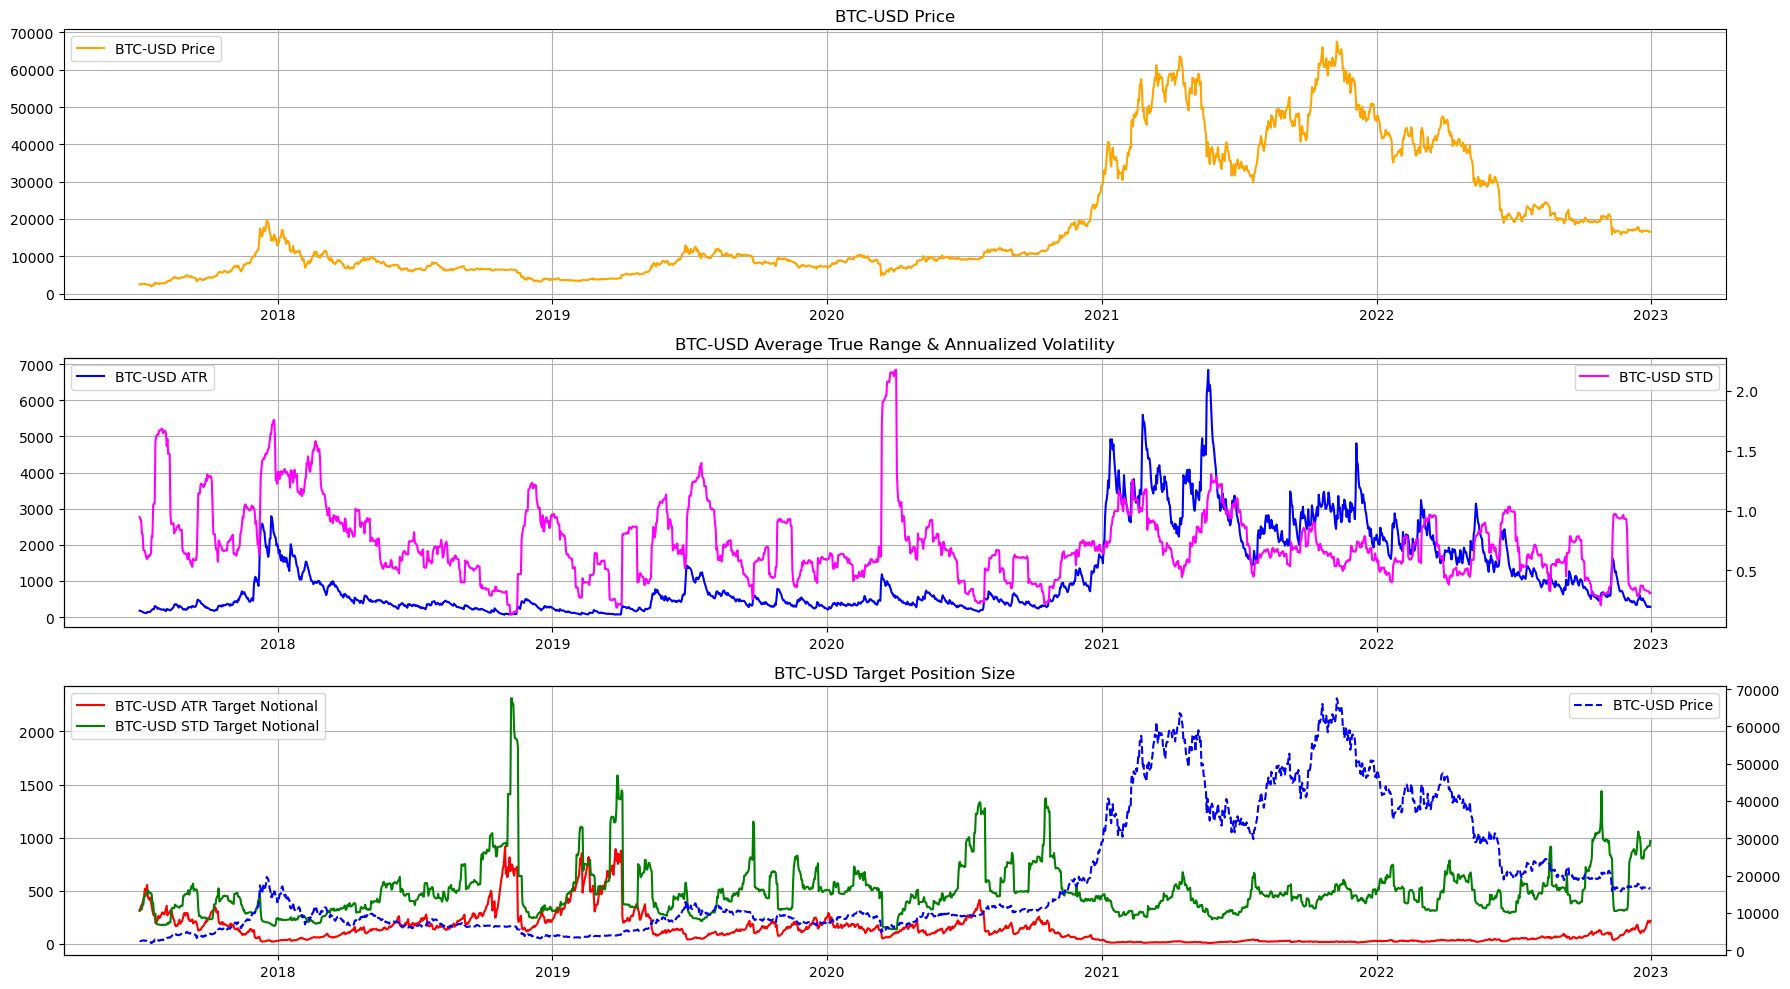

In [42]:
fig = plt.figure(figsize=(18,10))
layout = (3,2)
price_ax = plt.subplot2grid(layout, (0,0), colspan=2)
strategy_vol_ax = plt.subplot2grid(layout, (1,0), colspan=2)
strategy_vol_ax2 = strategy_vol_ax.twinx()
strategy_target_position_ax = plt.subplot2grid(layout, (2,0), colspan=2)
strategy_target_position_ax2 = strategy_target_position_ax.twinx()

date_cond = (df_atr.index > pd.Timestamp('2017-06-30').date())
df_atr_trim = df_atr[date_cond]
_ = price_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='orange')
_ = strategy_vol_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='blue')
_ = strategy_vol_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'], label=f'{ticker} STD', color='magenta')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_atr_vol_scaled_target_notional'], label=f'{ticker} ATR Target Notional', color='red')
_ = strategy_target_position_ax.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_std_vol_scaled_target_notional'], label=f'{ticker} STD Target Notional', color='green')
_ = strategy_target_position_ax2.plot(df_atr_trim.index, df_atr_trim[f'{ticker}_close'], label=f'{ticker} Price', color='blue', linestyle='--')
# _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

_ = price_ax.grid()
_ = price_ax.legend(loc='upper left')
_ = price_ax.set_title(f'{ticker} Price')

_ = strategy_vol_ax.grid()
_ = strategy_vol_ax.legend(loc='upper left')
_ = strategy_vol_ax2.legend(loc='upper right')
_ = strategy_vol_ax.set_title(f'{ticker} Average True Range & Annualized Volatility')

_ = strategy_target_position_ax.grid()
_ = strategy_target_position_ax.legend(loc='upper left')
_ = strategy_target_position_ax2.legend(loc='upper right')
_ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

plt.tight_layout()

In [110]:
df_atr[[f'{ticker}_close', f'{ticker}_atr_vol_scaled_target_notional', f'{ticker}_std_vol_scaled_target_notional']].corr()

BTC-USD_close  \
BTC-USD_close                                1.000000   
BTC-USD_atr_vol_scaled_target_notional      -0.371363   
BTC-USD_std_vol_scaled_target_notional      -0.230030   

                                        BTC-USD_atr_vol_scaled_target_notional  \
BTC-USD_close                                                        -0.371363   
BTC-USD_atr_vol_scaled_target_notional                                1.000000   
BTC-USD_std_vol_scaled_target_notional                                0.646277   

                                        BTC-USD_std_vol_scaled_target_notional  
BTC-USD_close                                                        -0.230030  
BTC-USD_atr_vol_scaled_target_notional                                0.646277  
BTC-USD_std_vol_scaled_target_notional                                1.000000

In [48]:
def apply_position_sizing_strategy(start_date, end_date, ticker, fast_mavg, slow_mavg, mavg_stepsize, rolling_donchian_window, price_or_returns_calc='price',
                                   long_only=False, include_signal_strength=False, position_size_with_atr=True, position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, 
                                   position_size_rolling_std_window=20, position_size_std_multiplier=0.01, risk_per_trade=0.05, initial_capital=15000, use_coinbase_data=True,
                                   high_volatility_threshold=1.5, stop_loss_multiplier=1.5, take_profit_multiplier=3, apply_position_sizing_pyramid=True, position_sizing_pyramid_factor=0.5):

    close_price_col = f'{ticker}'
    t_1_close_price_col = f'{ticker}_t_1'
    signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
    returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
    trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
    target_position_notional_col = f'{ticker}_vol_scaled_target_notional'
    actual_position_notional_col = f'{ticker}_actual_position_notional'
    actual_position_shares_col = f'{ticker}_actual_position_share_count'
    actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
    atr_col = f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'
    std_col = f'{ticker}_{position_size_rolling_std_window}_annualized_volatility'
    
    df = generate_trend_signal_with_donchian_channel(start_date=start_date, end_date=end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, 
                                                     mavg_stepsize=mavg_stepsize, rolling_donchian_window=rolling_donchian_window, price_or_returns_calc=price_or_returns_calc,
                                                     long_only=long_only, include_signal_strength=include_signal_strength)
    trend_cols = [close_price_col, signal_col, returns_col, trades_col]
    df = df[trend_cols]
    df[t_1_close_price_col] = df[close_price_col].shift(1)
    
    df_position = get_volatility_scaled_target_position_size(start_date=start_date, end_date=end_date, ticker=ticker, position_size_with_atr=position_size_with_atr, 
                                                             position_size_rolling_atr_window=position_size_rolling_atr_window, position_size_atr_multiplier=position_size_atr_multiplier,
                                                             position_size_rolling_std_window=position_size_rolling_std_window, position_size_std_multiplier=position_size_std_multiplier,
                                                             risk_per_trade=risk_per_trade, initial_capital=initial_capital, high_volatility_threshold=high_volatility_threshold,
                                                             use_coinbase_data=use_coinbase_data, price_or_returns_calc=price_or_returns_calc)
    df = pd.merge(df, df_position, left_index=True, right_index=True, how='left')

    if apply_position_sizing_pyramid:
        ## Apply Position Sizing Pyramid Factor
        df[target_position_notional_col] = np.where((df[signal_col] == 1) | (df[signal_col] == -1), df[target_position_notional_col] * (1 + position_sizing_pyramid_factor),
                                                    df[target_position_notional_col])
    df[actual_position_notional_col] = 0.0
    df[actual_position_entry_price_col] = 0.0
    df[actual_position_shares_col] = 0.0
    df['portfolio_value'] = initial_capital
    df['event'] = np.nan
    
    position = 0
    entry_price = None
    
    for i in range(1, len(df)):
        ## Taking a New Long position
        if (df[signal_col][i] == 1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Long Position: {df.index[i]}')
            # position = df[position_col][i]
            # entry_price = df[close_price_col][i]
            # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
            # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Long Position'
            
        ## Taking a New Short position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 0) and (df[actual_position_notional_col][i-1] == 0):
            # print(f'Take a New Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - df[actual_position_notional_col][i]
            df['event'][i] = 'New Short Position'
            
        ## Amending an Existing Long Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Amending an Existing Long Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Long Position'
            # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
            
        ## Amending an Existing Short Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Amending an Existing Short Position: {df.index[i]}')
            df[actual_position_shares_col][i] = df[actual_position_shares_col][i-1]
            df[actual_position_notional_col][i] = df[actual_position_shares_col][i] * df[t_1_close_price_col][i]
            df[actual_position_entry_price_col][i] = df[actual_position_entry_price_col][i-1]
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'Existing Short Position'
            
        ## Taking a New Long Position with an Existing Short Position
        elif (df[signal_col][i] == 1) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Take a New Long Position with an Existing Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Long with Existing Short Position'
            
        ## Taking a New Short Position with an Existing Long Position
        elif (df[signal_col][i] == -1) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Take a New Short Position with an Existing Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = -df[target_position_notional_col][i]
            df[actual_position_entry_price_col][i] = df[t_1_close_price_col][i]
            df[actual_position_shares_col][i] = df[actual_position_notional_col][i]/df[actual_position_entry_price_col][i]
            df['portfolio_value'][i] = df['portfolio_value'][i-1] - (df[actual_position_notional_col][i-1] + df[actual_position_notional_col][i])
            df['event'][i] = 'New Short with Existing Long Position'
        
        ## Closing a Long Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 1) and (df[actual_position_notional_col][i-1] > 0):
            # print(f'Closing a Long Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i]
            df['event'][i] = 'Closing Long Position'
            
        ## Closing a Short Position
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == -1) and (df[actual_position_notional_col][i-1] < 0):
            # print(f'Closing a Short Position: {df.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1] + (df[actual_position_shares_col][i-1] * df[t_1_close_price_col][i])
            df['event'][i] = 'Closing Short Position'
    
        elif (df[signal_col][i] == 0) and (df[signal_col][i-1] == 0):
            # print(f'Other: {df_test.index[i]}')
            df[actual_position_notional_col][i] = 0
            df[actual_position_entry_price_col][i] = 0
            df[actual_position_shares_col][i] = 0
            df['portfolio_value'][i] = df['portfolio_value'][i-1]
            df['event'][i] = 'No Event'
        
        
            
        # elif df[signal_col][i] == -1 and position > 0:
        #     initial_capital += position * (df[close_price_col][i] - entry_price)
        #     position = 0
        #     entry_price = None
        
        # # Stop-loss and take-profit logic
        # if position > 0:
        #     if df[close_price_col][i] <= stop_loss or df[close_price_col][i] >= take_profit:
        #         initial_capital += position * (df[close_price_col][i] - entry_price)
        #         position = 0
        #         entry_price = None
        
        # df.at[df.index[i], 'Capital'] = initial_capital

    return df

In [70]:
df_strategy_atr = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                 rolling_donchian_window=20, position_size_with_atr=True, position_size_atr_multiplier=0.05)
df_strategy_std = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', fast_mavg=50, slow_mavg=250, mavg_stepsize=6,
                                                 rolling_donchian_window=20, position_size_with_atr=False, position_size_std_multiplier=10)

In [71]:
print(df_strategy_atr.shape)
print(df_strategy_std.shape)

(2547, 17)
(2547, 17)


In [26]:
def apply_pyramiding(df, ticker, position_col, atr_col, close_col, rolling_atr_window, add_position_atr_multiplier, max_pyramid_levels=3, risk_per_trade=0.05, initial_capital=15000):
    """
    Adjusts the target position by adding to the base position incrementally during a confirmed trend.
    
    Parameters:
    - df: DataFrame containing the price and ATR data.
    - ticker: Ticker symbol.
    - base_position_size: Initial position size.
    - atr_window: Number of periods for ATR calculation.
    - atr_multiplier: ATR-based threshold for adding positions.
    - max_pyramid_levels: Maximum number of incremental adds allowed.
    - risk_per_trade: Risk percentage for each add.
    
    Returns:
    - df with adjusted target positions considering pyramiding.
    """
    # df['current_position'] = base_position_size
    for level in range(1, max_pyramid_levels + 1):
        add_threshold = level * add_position_atr_multiplier * df[f'{ticker}_{rolling_atr_window}_avg_true_range_price']
        df[f'add_level_{level}'] = np.where(
            df[close_col].shift(1) > df[close_col].shift(1).cummax() + add_threshold, 
            df[position_col] * (1 + (level * risk_per_trade)),
            0
        )
        df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[position_col] + df[f'add_level_{level}']

    df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'] = df[f'{ticker}_vol_scaled_target_notional_w_pyramiding'].clip(upper=initial_capital)
    
    return df

In [54]:
df_strategy_atr_pyramid = apply_pyramiding(df_strategy_atr, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', close_col=f'{ticker}',
                                           rolling_atr_window=20, add_position_atr_multiplier=2)

In [62]:
df_strategy_atr_pyramid.head(500)

BTC-USD  BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                                      
2016-01-11   449.19                                                  0    
2016-01-12   434.01                                                  0    
2016-01-13   432.77                                                  0    
2016-01-14   430.03                                                  0    
2016-01-15   357.53                                                  0    
2016-01-16   388.70                                                  0    
2016-01-17   378.46                                                  0    
2016-01-18   384.89                                                  0    
2016-01-19   375.27                                                  0    
2016-01-20   418.54                                                  0    
2016-01-21   409.38                                                  0    
2016-01-22   382.90                                                  0    
2016-01-23   387.50                                                  0    
2016-01-24   403.05                                                  0    
2016-01-25   391.40                                                  0    
2016-01-26   391.54                                                  0    
2016-01-27   394.79                                                  0    
2016-01-28   379.61                                                  0    
2016-01-29   378.68                                                  0    
2016-01-30   378.46                                                  0    
2016-01-31   367.95                                                  0    
2016-02-01   371.33                                                  0    
2016-02-02   372.93                                                  0    
2016-02-03   368.87                                                  0    
2016-02-04   387.99                                                  0    
2016-02-05   384.50                                                  0    
2016-02-06   375.44                                                  0    
2016-02-07   377.49                                                  0    
2016-02-08   371.14                                                  0    
2016-02-09   372.68                                                  0    
2016-02-10   378.44                                                  0    
2016-02-11   378.23                                                  0    
2016-02-12   382.05                                                  0    
2016-02-13   391.00                                                  0    
2016-02-14   406.59                                                  0    
2016-02-15   398.95                                                  0    
2016-02-16   407.42                                                  0    
2016-02-17   415.20                                                  0    
2016-02-18   421.19                                                  0    
2016-02-19   420.72                                                  0    
2016-02-20   437.46                                                  0    
2016-02-21   438.56                                                  0    
2016-02-22   437.55                                                  0    
2016-02-23   419.97                                                  0    
2016-02-24   423.94                                                  0    
2016-02-25   423.54                                                  0    
2016-02-26   430.85                                                  0    
2016-02-27   433.12                                                  0    
2016-02-28   433.73                                                  0    
2016-02-29   436.44                                                  0    
2016-03-01   433.08                                                  0    
2016-03-02   420.39                  

In [66]:
df_strategy_atr_pyramid[df_strategy_atr_pyramid.add_level_2 != 0].head()

Empty DataFrame
Columns: [BTC-USD, BTC-USD_50_6_250_mavg_crossover_20_donchian_signal, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades, BTC-USD_t_1, BTC-USD_close, BTC-USD_20_avg_true_range_price, BTC-USD_pct_returns, BTC-USD_20_std_dev, BTC-USD_20_annualized_volatility, BTC-USD_volatility_regime, BTC-USD_vol_scaled_target_notional, BTC-USD_actual_position_notional, BTC-USD_actual_position_entry_price, BTC-USD_actual_position_share_count, portfolio_value, event, add_level_1, BTC-USD_vol_scaled_target_notional_w_pyramiding, add_level_2, add_level_3]
Index: []

In [26]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=True, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price', rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

NameError: name 'get_volatility_scaled_target_position_size' is not defined

In [146]:
df_position[['SOL-USD_20_annualized_volatility','SOL-USD_pct_returns']].corr()

SOL-USD_20_annualized_volatility  \
SOL-USD_20_annualized_volatility                          1.000000   
SOL-USD_pct_returns                                       0.030043   

                                  SOL-USD_pct_returns  
SOL-USD_20_annualized_volatility             0.030043  
SOL-USD_pct_returns                          1.000000

In [150]:
df_position[['SOL-USD_20_avg_true_range_price','SOL-USD_pct_returns']].corr()

SOL-USD_20_avg_true_range_price  \
SOL-USD_20_avg_true_range_price                         1.000000   
SOL-USD_pct_returns                                     0.013363   

                                 SOL-USD_pct_returns  
SOL-USD_20_avg_true_range_price             0.013363  
SOL-USD_pct_returns                         1.000000

In [152]:
df_position.head()

SOL-USD_close  SOL-USD_20_avg_true_range_price  \
date                                                         
2021-06-17            NaN                              NaN   
2021-06-18         39.250                         2.281000   
2021-06-19         36.842                         2.487571   
2021-06-20         35.200                         2.477707   
2021-06-21         35.271                         2.682688   

            SOL-USD_pct_returns  SOL-USD_20_std_dev  \
date                                                  
2021-06-17                  NaN                 NaN   
2021-06-18                  NaN                 NaN   
2021-06-19            -0.061350                 NaN   
2021-06-20            -0.044569                 NaN   
2021-06-21             0.002017                 NaN   

            SOL-USD_20_annualized_volatility SOL-USD_volatility_regime  \
date                                                                     
2021-06-17                               NaN                      None   
2021-06-18                               NaN                       Low   
2021-06-19                               NaN                       Low   
2021-06-20                               NaN                       Low   
2021-06-21                               NaN                       Low   

            SOL-USD_vol_scaled_target_notional     low    high    open  \
date                                                                     
2021-06-17                                 NaN  38.219  40.500  40.500   
2021-06-18                                 0.0  35.000  39.450  39.321   
2021-06-19                                 0.0  34.977  37.361  36.875   
2021-06-20                                 0.0  31.324  35.954  35.200   
2021-06-21                                 0.0  26.000  35.532  35.286   

             close      volume  
date                            
2021-06-17  39.250  202117.954  
2021-06-18  36.842  471361.712  
2021-06-19  35.200  263002.615  
2021-06-20  35.271  287189.023  
2021-06-21  26.625  836374.380

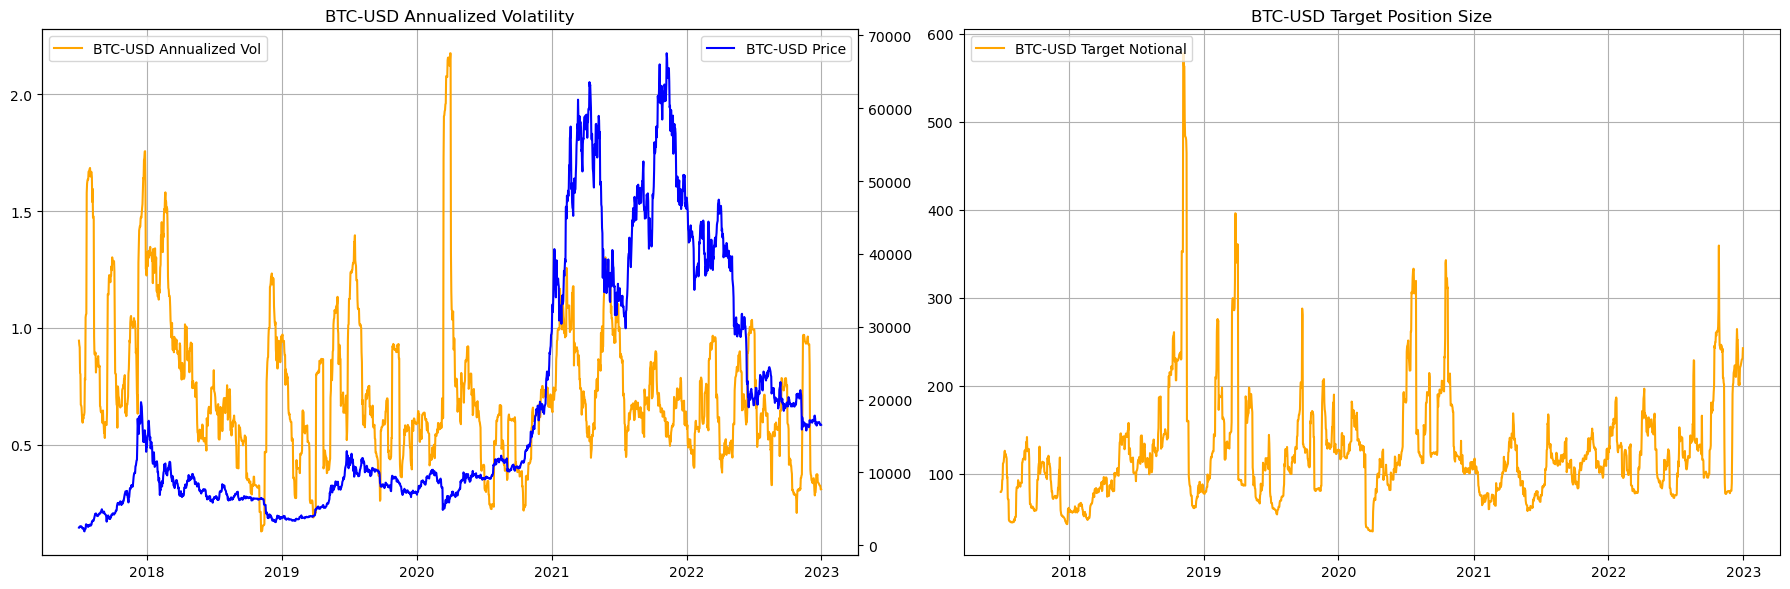

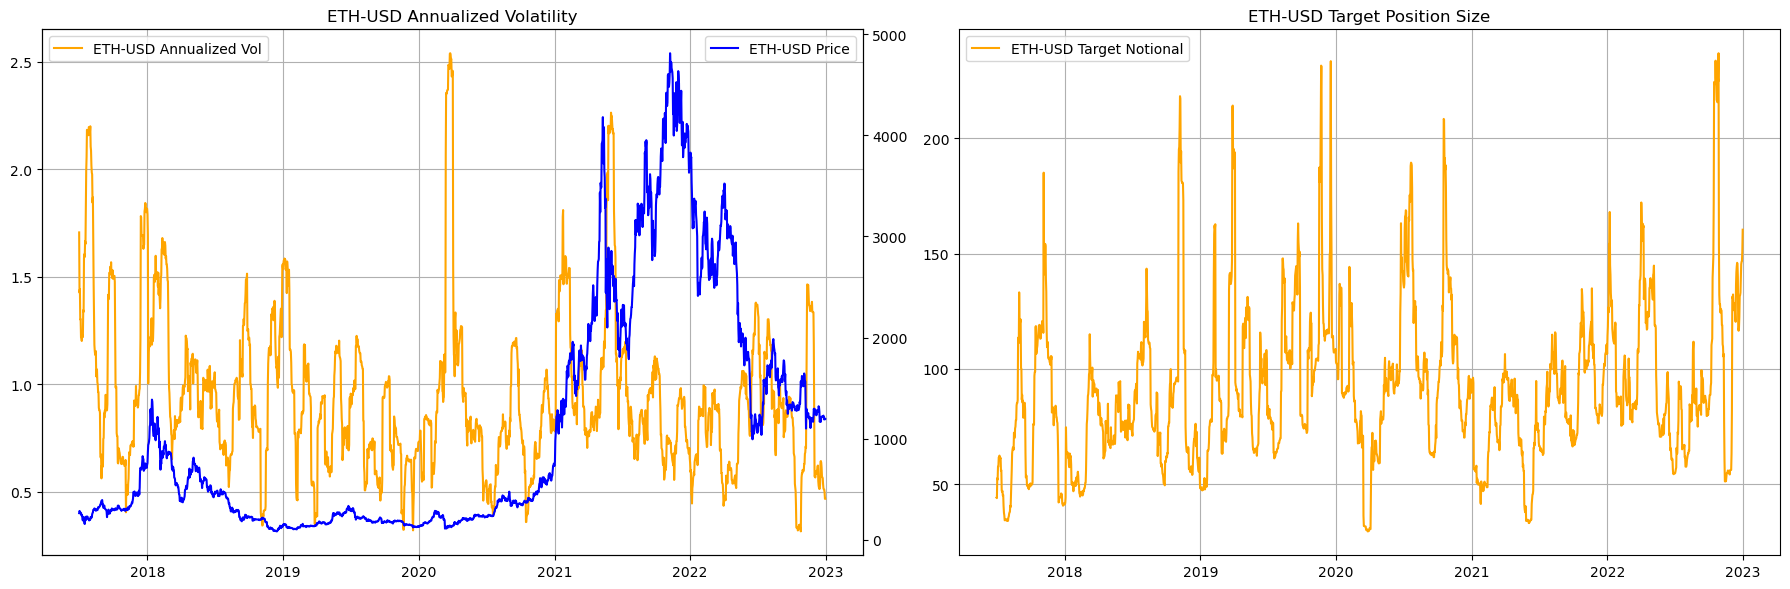

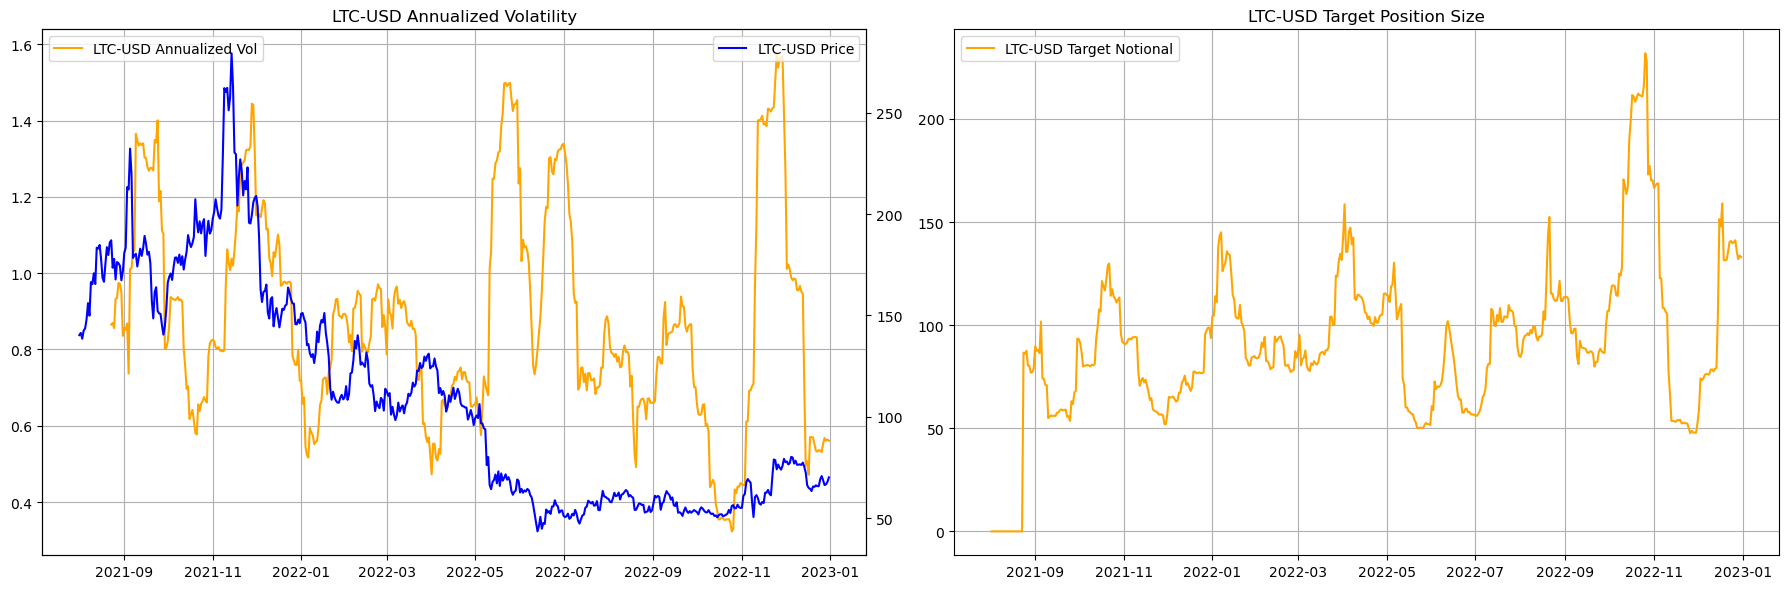

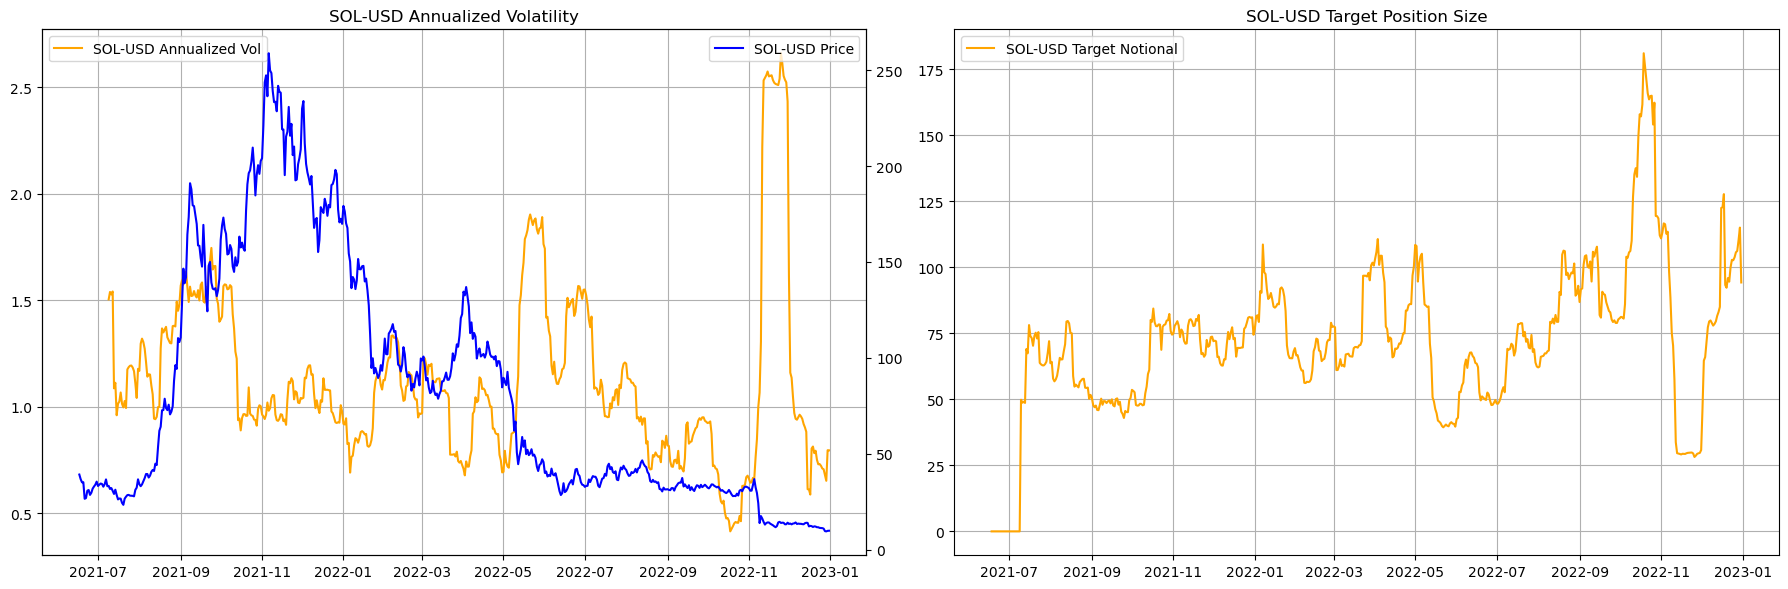

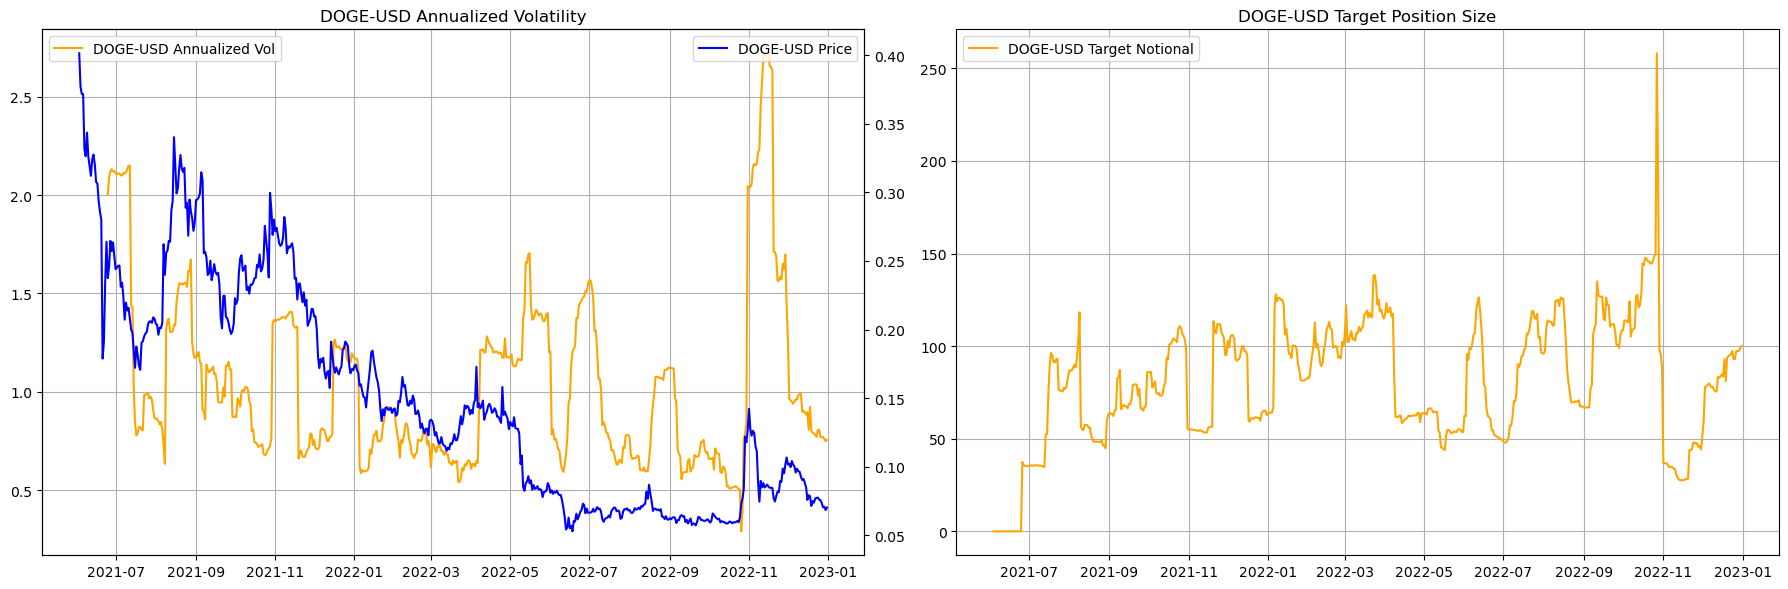

In [74]:
ticker_list = ['BTC-USD','ETH-USD','LTC-USD','SOL-USD','DOGE-USD']

for ticker in ticker_list:
    df_position = get_volatility_scaled_target_position_size(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, position_size_with_atr=False, position_size_rolling_atr_window=20,
                                                             position_size_atr_multiplier=0.05, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05)
    # df_price = cn.get_coinbase_ohlc_data(ticker=ticker)
    df_price = cn.save_historical_crypto_prices_from_coinbase(ticker=ticker, end_date=in_sample_end_date, save_to_file=False)
    df_position = pd.merge(df_position, df_price, left_index=True, right_index=True, how='left')
    # df_position = apply_pyramiding(df_position, ticker=ticker, position_col=f'{ticker}_vol_scaled_target_notional', atr_col=f'{ticker}_{rolling_atr_window}_avg_true_range_price',
    # rolling_atr_window=20, add_position_atr_multiplier=2)
    df_position = df_position[df_position.index > pd.Timestamp('2017-06-30').date()]

    fig = plt.figure(figsize=(18,6))
    layout = (1,2)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    # strategy_target_position_pyramid_ax = plt.subplot2grid(layout, (0,1))#, colspan=2)
    _ = strategy_atr_ax.plot(df_position.index, df_position[f'{ticker}_20_annualized_volatility'], label=f'{ticker} Annualized Vol', color='orange')
    _ = strategy_atr_ax2.plot(df_position.index, df_position[f'close'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Notional', color='orange')
    # _ = strategy_target_position_pyramid_ax.plot(df_position.index, df_position[f'{ticker}_vol_scaled_target_notional_w_pyramiding'], label=f'{ticker} Target Notional', color='orange')    

    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Annualized Volatility')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')

    # _ = strategy_target_position_pyramid_ax.grid()
    # _ = strategy_target_position_pyramid_ax.legend(loc='upper left')
    # _ = strategy_target_position_pyramid_ax.set_title(f'{ticker} Target Position Size with Pyramiding')
    
    plt.tight_layout()

In [74]:
def get_portfolio_performance(df_strategy, rolling_sharpe_window=50, annual_trading_days=252):

    short_position_event_list = ['New Short Position', 'Existing Short Position']
    df_strategy['portfolio_value_adj'] = np.where(df_strategy['event'].isin(short_position_event_list),
                                                  df_strategy['portfolio_value'] + (df_strategy[f'{ticker}_actual_position_share_count'] * df_strategy[f'{ticker}_actual_position_entry_price']),
                                                  df_strategy['portfolio_value'])
    df_strategy['strategy_pct_returns'] = df_strategy['portfolio_value_adj'].pct_change()
    
    # Calculate rolling mean and standard deviation for 50-day intervals
    rolling_mean = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).mean()
    rolling_std = df_strategy['strategy_pct_returns'].rolling(window=rolling_sharpe_window).std()
    
    # Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
    df_strategy[f'{ticker}_rolling_sharpe_ratio_{rolling_sharpe_window}d'] = (rolling_mean * np.sqrt(annual_trading_days))

    # Overall Sharpe Ratio
    sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annual_trading_days) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annual_trading_days))
    print("Overall Sharpe Ratio:", sharpe_ratio)

    return df_strategy    

In [96]:
df_strategy_atr = get_portfolio_performance(df_strategy_atr, rolling_sharpe_window=50, annual_trading_days=365)
df_strategy_std = get_portfolio_performance(df_strategy_std, rolling_sharpe_window=50, annual_trading_days=365)

Overall Sharpe Ratio: 0.3037560474145205
Overall Sharpe Ratio: 0.2547104628600761


In [84]:
short_position_event_list = ['New Short Position', 'Existing Short Position']
df_strategy_atr['portfolio_value_adj'] = np.where(df_strategy_atr['event'].isin(short_position_event_list),
                                              df_strategy_atr['portfolio_value'] + (df_strategy_atr[f'{ticker}_actual_position_share_count'] * df_strategy_atr[f'{ticker}_actual_position_entry_price']),
                                              df_strategy_atr['portfolio_value'])
df_strategy_atr['strategy_pct_returns'] = df_strategy_atr['portfolio_value_adj'].pct_change()

# Calculate rolling mean and standard deviation for 50-day intervals
rolling_mean = df_strategy_atr['strategy_pct_returns'].rolling(window=50).mean()
rolling_std = df_strategy_atr['strategy_pct_returns'].rolling(window=50).std()

# Calculate rolling Sharpe ratio (assuming risk-free rate = 0)
df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'] = (rolling_mean * np.sqrt(annualization_factor))

In [82]:
# Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
annualization_factor = 365  # number of trading days in a year
sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
print("Overall Sharpe Ratio:", sharpe_ratio)

Overall Sharpe Ratio: -0.3501272235336938


In [68]:
all_ticker_non_pyramid_atr_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_atr = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20,
                                                     position_size_rolling_atr_window=20, position_size_atr_multiplier=0.05, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_atr = get_portfolio_performance(df_strategy_atr, rolling_sharpe_window=50, annual_trading_days=365)

    df_strategy_atr = df_strategy_atr[df_strategy_atr.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_atr_df[ticker] = df_strategy_atr
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_{rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_atr.index, df_strategy_atr[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Average True Range Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy_atr['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy_atr['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

NameError: name 'ticker_list' is not defined

BTC-USD
Overall Sharpe Ratio: 0.23846295941209944
ETH-USD
Overall Sharpe Ratio: 0.5164123249301095
LTC-USD
Overall Sharpe Ratio: 0.6891836521616819
SOL-USD
Overall Sharpe Ratio: 0.9996131001725634


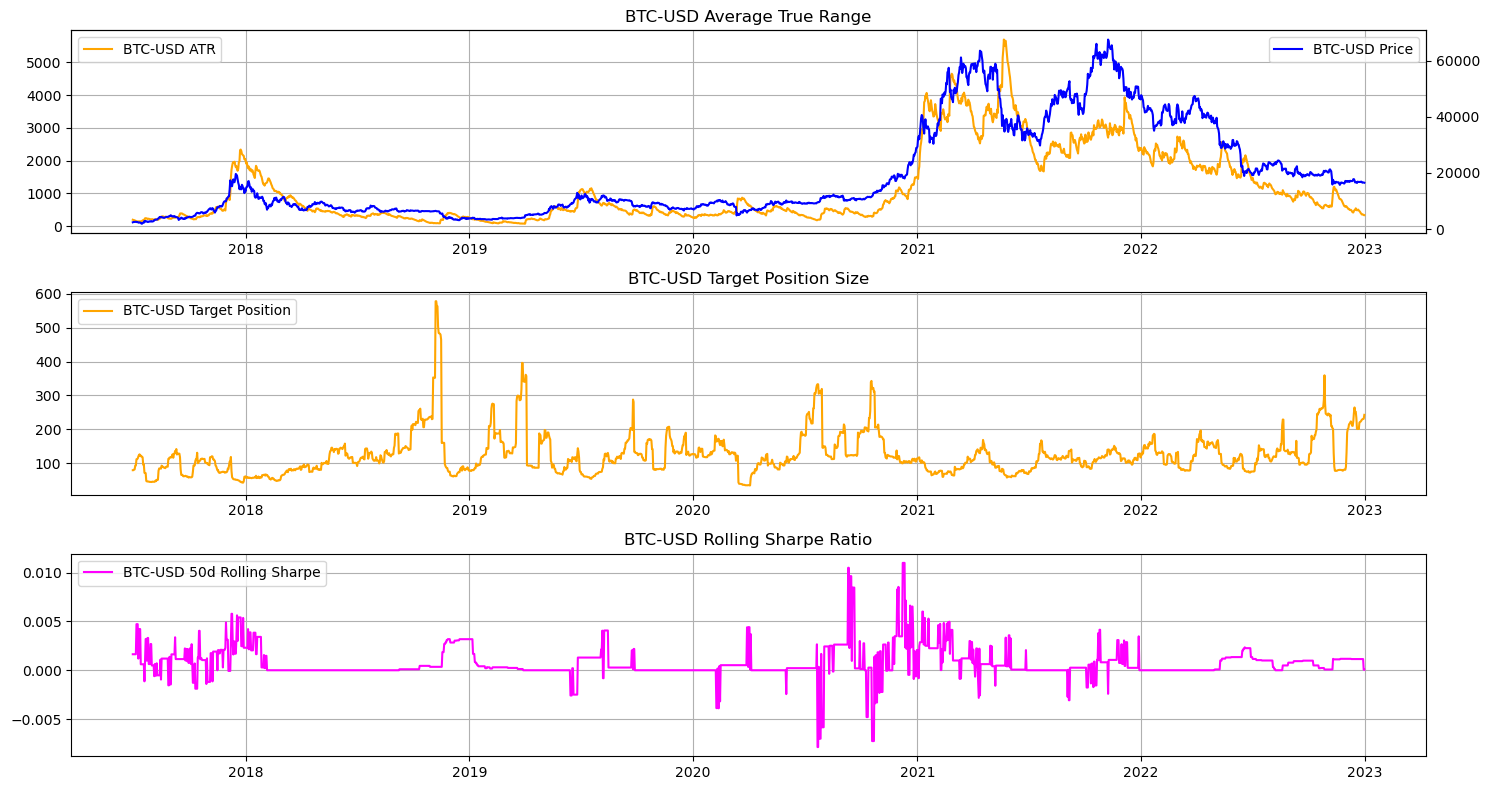

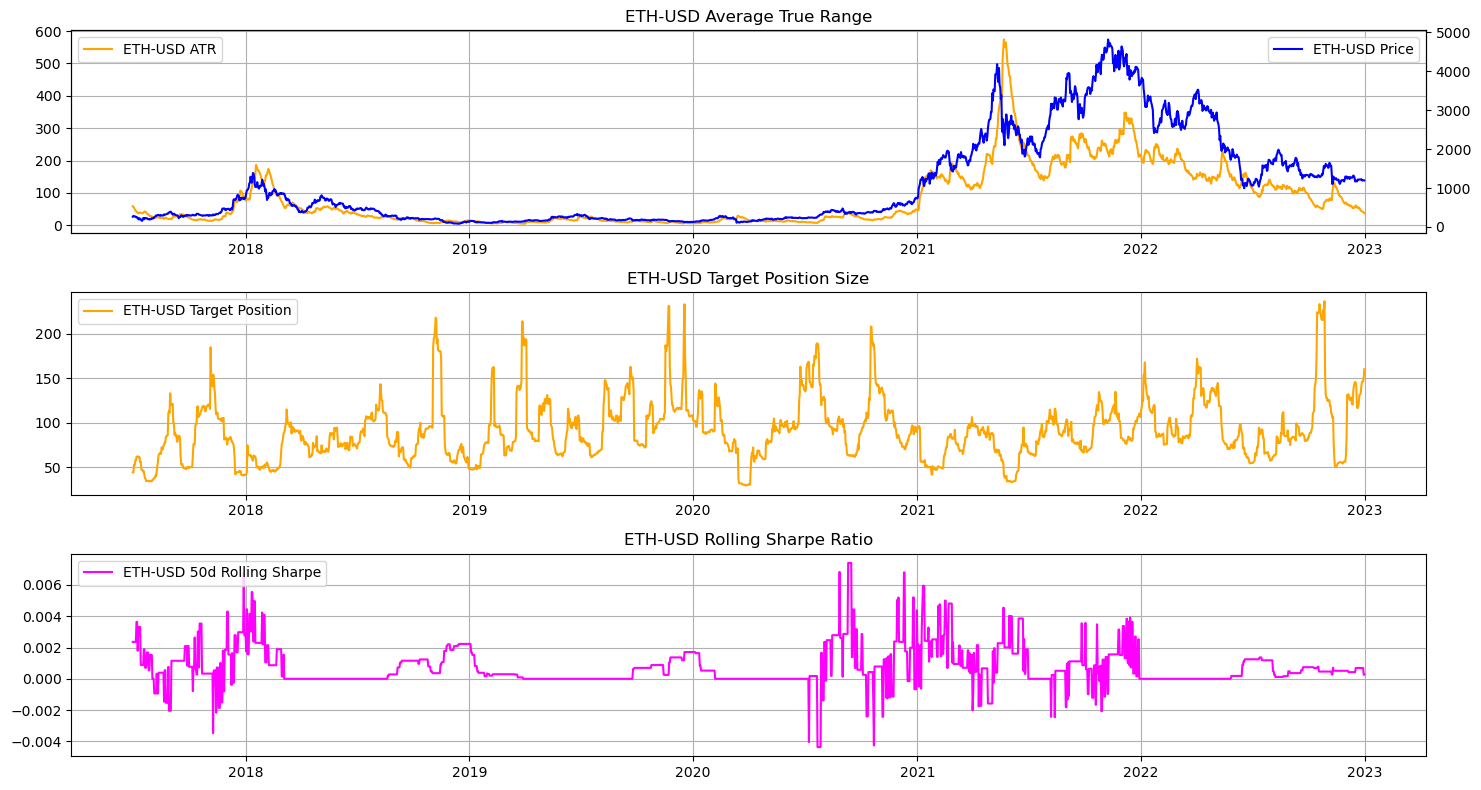

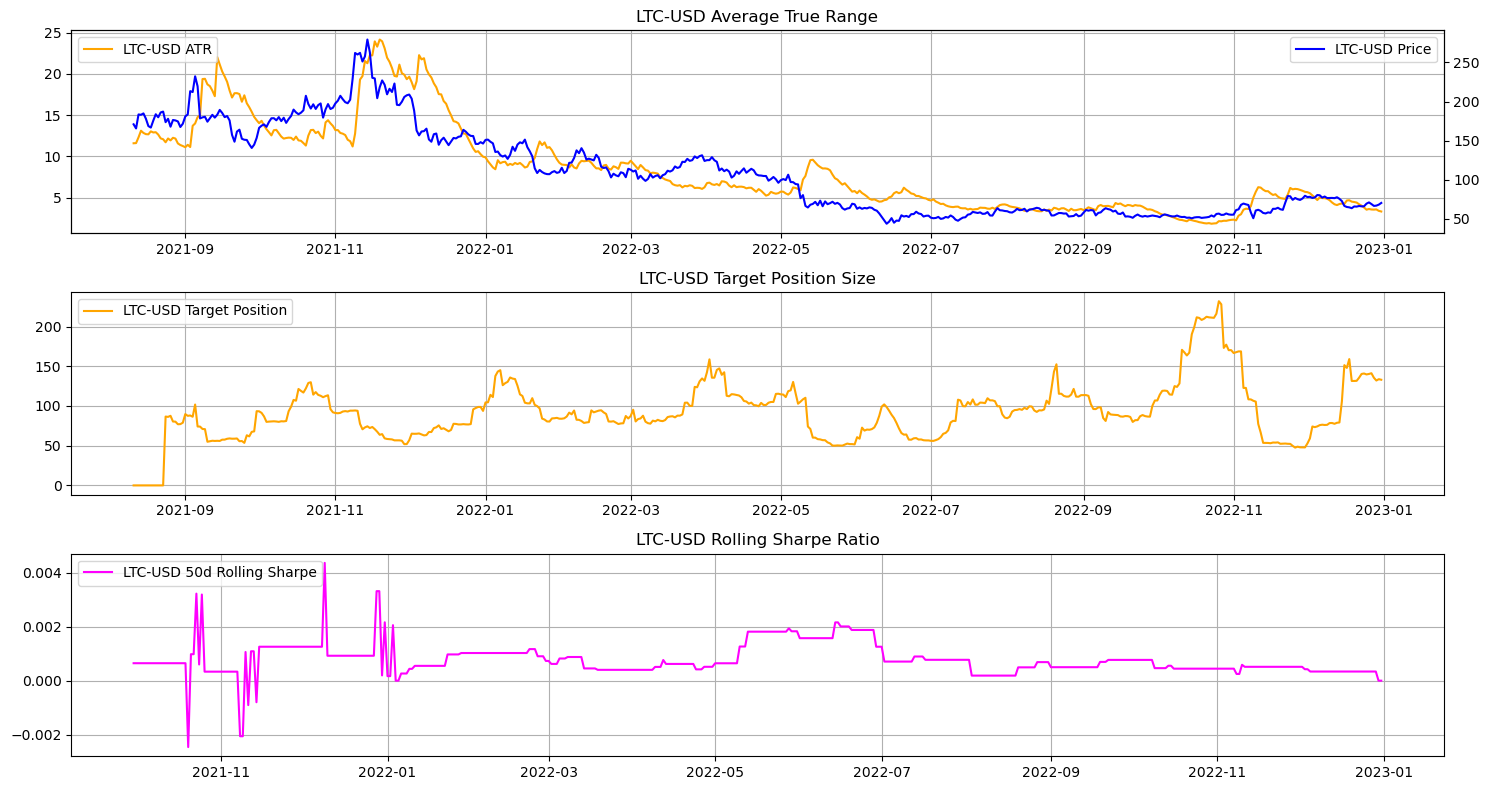

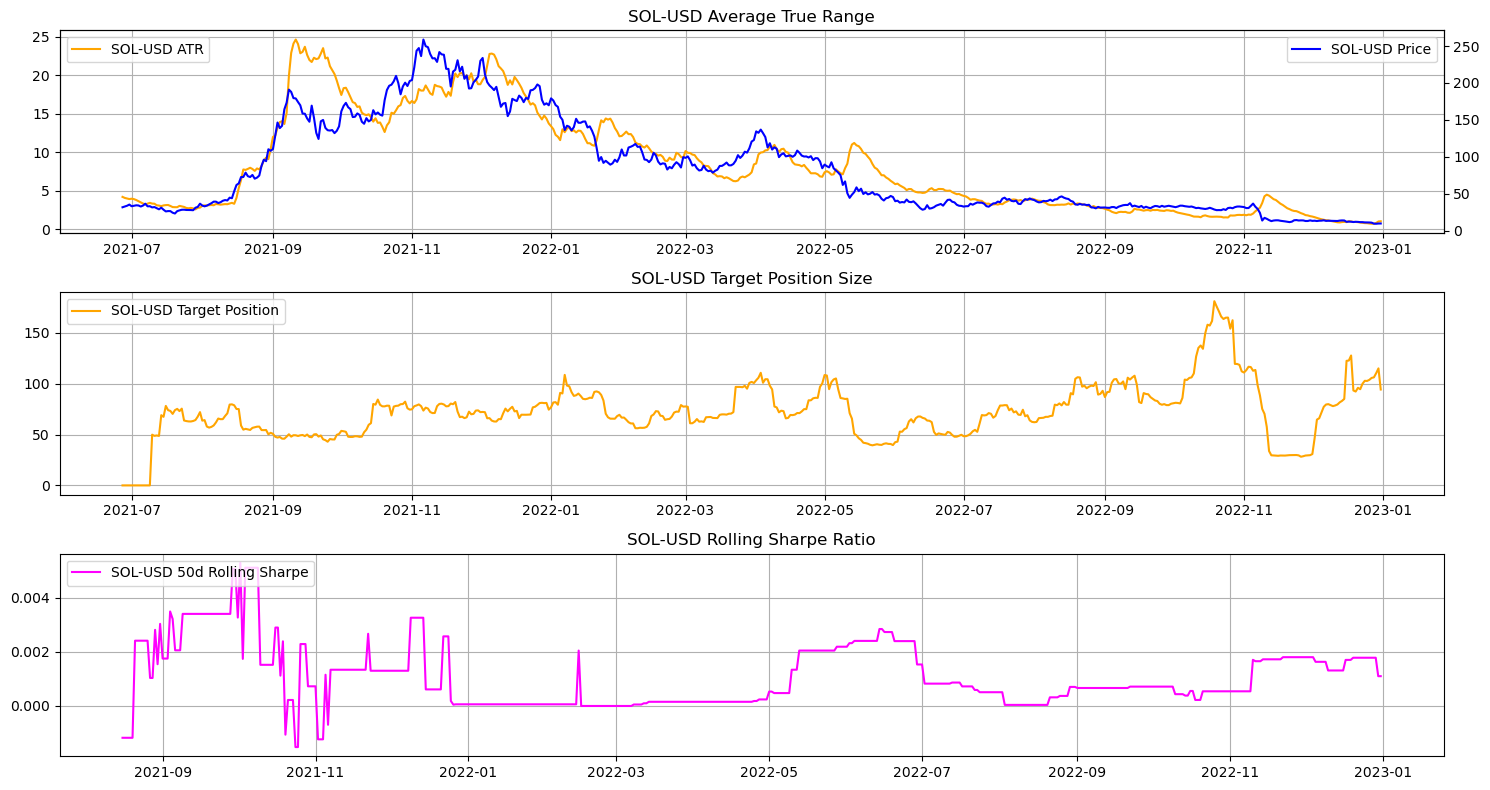

In [117]:
all_ticker_non_pyramid_std_df = {}
for ticker in ticker_list:
    print(ticker)
    df_strategy_std = apply_position_sizing_strategy(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=50, slow_mavg=250, mavg_stepsize=6, rolling_donchian_window=20, position_size_with_atr=False,
                                                     position_size_rolling_atr_window=20, position_size_atr_multiplier=0.01, position_size_rolling_std_window=20, position_size_std_multiplier=10, risk_per_trade=0.05, position_sizing_pyramid_factor=False)
    df_strategy_std = get_portfolio_performance(df_strategy_std, rolling_sharpe_window=50, annual_trading_days=365)
    
    df_strategy_std = df_strategy_std[df_strategy_std.index > pd.Timestamp('2017-06-30').date()]
    all_ticker_non_pyramid_std_df[ticker] = df_strategy_std
    
    fig = plt.figure(figsize=(15,8))
    layout = (3,1)
    strategy_atr_ax = plt.subplot2grid(layout, (0,0))#, colspan=2)
    strategy_atr_ax2 = strategy_atr_ax.twinx()
    strategy_target_position_ax = plt.subplot2grid(layout, (1,0))#, colspan=2)
    sharpe_ax = plt.subplot2grid(layout, (2,0))
    
    _ = strategy_atr_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_{position_size_rolling_atr_window}_avg_true_range_price'], label=f'{ticker} ATR', color='orange')
    _ = strategy_atr_ax2.plot(df_strategy_std.index, df_strategy_std[f'{ticker}'], label=f'{ticker} Price', color='blue')
    _ = strategy_target_position_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_vol_scaled_target_notional'], label=f'{ticker} Target Position', color='orange')
    _ = sharpe_ax.plot(df_strategy_std.index, df_strategy_std[f'{ticker}_rolling_sharpe_ratio_50d'], label=f'{ticker} 50d Rolling Sharpe', color='magenta')
    
    _ = strategy_atr_ax.grid()
    _ = strategy_atr_ax.legend(loc='upper left')
    _ = strategy_atr_ax2.legend(loc='upper right')
    _ = strategy_atr_ax.set_title(f'{ticker} Average True Range')
    
    _ = strategy_target_position_ax.grid()
    _ = strategy_target_position_ax.legend(loc='upper left')
    _ = strategy_target_position_ax.set_title(f'{ticker} Target Position Size')
    
    _ = sharpe_ax.grid()
    _ = sharpe_ax.legend(loc='upper left')
    _ = sharpe_ax.set_title(f'{ticker} Rolling Sharpe Ratio')

    plt.tight_layout()

    # # Calculate overall Sharpe Ratio (assuming risk-free rate = 0)
    # annualization_factor = 365  # number of trading days in a year
    # sharpe_ratio = (df_strategy['strategy_pct_returns'].mean() * annualization_factor) / (df_strategy['strategy_pct_returns'].std() * np.sqrt(annualization_factor))
    # print(f"{ticker} Overall Sharpe Ratio:", sharpe_ratio)

## Position Sizing based on Realized Volatility 

In [195]:
ticker_list = ['BTC-USD','ETH-USD']

## Strategy Parameters
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20

## Volatility Parameters
volatility_window = 20
annual_trading_days = 365

In [197]:
ticker_signal_dict = {}
for ticker in ticker_list:
    df_trend = generate_trend_signal_with_donchian_channel(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker=ticker, fast_mavg=fast_mavg, slow_mavg=slow_mavg, mavg_stepsize=mavg_stepsize,
                                                           rolling_donchian_window=rolling_donchian_window, price_or_returns_calc='price', long_only=False, include_signal_strength=False)
    df_trend = tf.get_returns_volatility(df_trend, vol_range_list = [volatility_window], close_px_col=f'{ticker}')
    df_trend[f'{ticker}_annualized_volatility_{volatility_window}'] = df_trend[f'{ticker}_volatility_{volatility_window}'] * np.sqrt(annual_trading_days)
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal']/df_trend[f'{ticker}_volatility_{volatility_window}']
    df_trend[f'{ticker}_vol_normalized_trend_signal'] = df_trend[f'{ticker}_vol_normalized_trend_signal'].fillna(0)
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                 f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    ticker_signal_dict[ticker] = df_trend[trend_cols]
df_signal = pd.concat(ticker_signal_dict, axis=1)
df_signal.columns = df_signal.columns.to_flat_index()
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades',
                  f'{ticker}_annualized_volatility_{volatility_window}',f'{ticker}_vol_normalized_trend_signal']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]
df_signal.columns = cols

In [231]:
vol_normalized_signal_cols = [f'{ticker}_vol_normalized_trend_signal' for ticker in ticker_list]
df_signal[vol_normalized_signal_cols] = df_signal[vol_normalized_signal_cols].fillna(0)
for ticker in ticker_list:
    df_signal[f'{ticker}_portfolio_normalized_weight'] = df_signal[f'{ticker}_vol_normalized_trend_signal']/df_signal[vol_normalized_signal_cols].abs().sum(axis=1)

In [223]:
ticker = 'BTC-USD'

In [233]:
df_signal[df_signal['BTC-USD_portfolio_normalized_weight'] < 1].head(200)

BTC-USD  BTC-USD_pct_returns  BTC-USD_trend_signal  \
date                                                              
2016-07-04    681.98             0.027775                   1.0   
2016-07-05    669.87            -0.017757                   1.0   
2016-07-07    641.97            -0.054244                   1.0   
2016-08-02    537.47            -0.111913                   1.0   
2016-10-28    689.95            -0.001823                   1.0   
2016-10-29    714.28             0.035263                   1.0   
2016-11-11    716.90             0.005597                   1.0   
2016-11-12    704.53            -0.017255                   1.0   
2016-11-17    730.71            -0.012354                   1.0   
2016-11-18    748.54             0.024401                   1.0   
2016-11-24    737.99            -0.004760                   1.0   
2016-11-27    729.24            -0.008781                   1.0   
2016-11-28    729.77             0.000727                   1.0   
2016-11-29    732.37             0.003563                   1.0   
2016-12-02    769.25             0.020225                   1.0   
2016-12-04    767.99             0.001317                   1.0   
2016-12-05    752.00            -0.020821                   1.0   
2017-03-11   1188.11             0.071325                   1.0   
2017-03-12   1235.58             0.039954                   1.0   
2017-03-13   1245.49             0.008021                   1.0   
2017-03-14   1247.42             0.001550                   1.0   
2017-03-15   1263.00             0.012490                   1.0   
2017-03-16   1175.11            -0.069588                   1.0   
2017-03-24    934.87            -0.088056                   1.0   
2017-03-29   1043.27            -0.002037                   1.0   
2017-04-24   1257.29             0.004241                   1.0   
2017-04-25   1281.16             0.018985                   1.0   
2017-04-26   1298.44             0.013488                   1.0   
2017-04-27   1349.26             0.039139                   1.0   
2017-04-28   1353.34             0.003024                   1.0   
2017-04-30   1384.55             0.014003                   1.0   
2017-05-03   1533.00             0.041447                   1.0   
2017-05-04   1563.39             0.019824                   1.0   
2017-05-18   1899.16             0.047391                   1.0   
2017-05-19   1976.23             0.040581                   1.0   
2017-05-21   2057.00            -0.000928                   1.0   
2017-05-22   2123.29             0.032227                   1.0   
2017-05-23   2272.75             0.070391                   1.0   
2017-05-24   2432.97             0.070496                   1.0   
2017-05-30   2191.58            -0.038561                   1.0   
2017-05-31   2303.29             0.050972                   1.0   
2017-06-04   2521.36            -0.010475                   1.0   
2017-06-05   2698.00             0.070057                   1.0   
2017-06-06   2871.29             0.064229                   1.0   
2017-06-09   2811.39             0.004165                   1.0   
2017-06-10   2931.15             0.042598                   1.0   
2017-06-11   2998.98             0.023141                   1.0   
2017-06-12   2655.71            -0.114462                   1.0   
2017-08-05   3243.49             0.135143                   1.0   
2017-08-06   3222.22            -0.006558                   1.0   
2017-08-07   3398.23             0.054624                   1.0   
2017-08-08   3422.43             0.007121                   1.0   
2017-08-10   3444.98             0.030567                   1.0   
2017-08-11   3656.15             0.061298                   1.0   
2017-08-21   4002.00            -0.012093                   1.0   
2017-08-24   4312.03             0.040676                   1.0   
2017-08-25   4360.00             0.011125                   1.0   
2017-08-26   4344.32            -0.003596                   

In [185]:
vol_normalized_signal_cols

['BTC-USD_vol_normalized_trend_signal', 'ETH-USD_vol_normalized_trend_signal']

In [235]:
returns_cols = [f'{ticker}_pct_returns' for ticker in ticker_list]

In [241]:
df_signal[returns_cols].rolling(20).cov(pairwise=True).dropna()

BTC-USD_pct_returns  ETH-USD_pct_returns
date                                                                    
2016-06-19 BTC-USD_pct_returns         1.399719e-03         1.736880e-03
           ETH-USD_pct_returns         1.736880e-03         1.070137e-02
2016-06-20 BTC-USD_pct_returns         1.932593e-03         2.073794e-03
           ETH-USD_pct_returns         2.073794e-03         1.028180e-02
2016-06-21 BTC-USD_pct_returns         2.145668e-03         1.478088e-03
           ETH-USD_pct_returns         1.478088e-03         1.187609e-02
2016-06-22 BTC-USD_pct_returns         2.716780e-03         1.784090e-03
           ETH-USD_pct_returns         1.784090e-03         1.203886e-02
2016-06-23 BTC-USD_pct_returns         2.628696e-03         1.892519e-03
           ETH-USD_pct_returns         1.892519e-03         1.213474e-02
2016-06-24 BTC-USD_pct_returns         2.782375e-03         2.025501e-03
           ETH-USD_pct_returns         2.025501e-03         1.224420e-02
2016-06-25 BTC-USD_pct_returns         2.776602e-03         2.028355e-03
           ETH-USD_pct_returns         2.028355e-03         1.226588e-02
2016-06-26 BTC-USD_pct_returns         2.955137e-03         2.121258e-03
           ETH-USD_pct_returns         2.121258e-03         1.231421e-02
2016-06-27 BTC-USD_pct_returns         2.965875e-03         2.137396e-03
           ETH-USD_pct_returns         2.137396e-03         1.230104e-02
2016-06-28 BTC-USD_pct_returns         2.990326e-03         2.290064e-03
           ETH-USD_pct_returns         2.290064e-03         1.324340e-02
2016-06-29 BTC-USD_pct_returns         2.998187e-03         2.248908e-03
           ETH-USD_pct_returns         2.248908e-03         1.333852e-02
2016-06-30 BTC-USD_pct_returns         3.106963e-03         2.192439e-03
           ETH-USD_pct_returns         2.192439e-03         1.320109e-02
2016-07-01 BTC-USD_pct_returns         3.012207e-03         2.164271e-03
           ETH-USD_pct_returns         2.164271e-03         1.320098e-02
2016-07-02 BTC-USD_pct_returns         2.470040e-03         1.523841e-03
           ETH-USD_pct_returns         1.523841e-03         1.260330e-02
2016-07-03 BTC-USD_pct_returns         2.567511e-03         1.170216e-03
           ETH-USD_pct_returns         1.170216e-03         1.128635e-02
2016-07-04 BTC-USD_pct_returns         2.563889e-03         1.230497e-03
           ETH-USD_pct_returns         1.230497e-03         1.109694e-02
2016-07-05 BTC-USD_pct_returns         2.559272e-03         1.283285e-03
           ETH-USD_pct_returns         1.283285e-03         1.126581e-02
2016-07-06 BTC-USD_pct_returns         1.996814e-03         3.998157e-04
           ETH-USD_pct_returns         3.998157e-04         9.878124e-03
2016-07-07 BTC-USD_pct_returns         2.104280e-03         2.649720e-04
           ETH-USD_pct_returns         2.649720e-04         7.103376e-03
2016-07-08 BTC-USD_pct_returns         2.201859e-03         8.030665e-04
           ETH-USD_pct_returns         8.030665e-04         4.936334e-03
2016-07-09 BTC-USD_pct_returns         2.186877e-03         7.573185e-04
           ETH-USD_pct_returns         7.573185e-04         4.800519e-03
2016-07-10 BTC-USD_pct_returns         1.845442e-03         5.814836e-04
           ETH-USD_pct_returns         5.814836e-04         4.711227e-03
2016-07-11 BTC-USD_pct_returns         1.720158e-03         1.050808e-03
           ETH-USD_pct_returns         1.050808e-03         2.981301e-03
2016-07-12 BTC-USD_pct_returns         1.247788e-03         8.394041e-04
           ETH-USD_pct_returns         8.394041e-04         2.895220e-03
2016-07-13 BTC-USD_pct_returns         1.186225e-03         7.118178e-04
           ETH-USD_pct_returns         7.118178e-04         2.713976e-03
2016-07-14 BTC-USD_pct_returns         9.976467e-04         5.592542e-04
           ETH-USD_pct_returns         5.592542e-04         3.236348e-03
2016-07-15 BTC-USD_pct_returns         1.000124e-03         5.792622e-04
           ETH-US

In [ ]:
normalized_weights = signals_normalized.div(signals_normalized.abs().sum(axis=1), axis=0)

In [189]:
df_signal.head()

BTC-USD  BTC-USD_pct_returns  BTC-USD_trend_signal  \
date                                                             
2016-01-11   449.19                  NaN                   1.0   
2016-01-12   434.01            -0.033794                   1.0   
2016-01-13   432.77            -0.002857                   1.0   
2016-01-14   430.03            -0.006331                   1.0   
2016-01-15   357.53            -0.168593                   1.0   

            BTC-USD_20_donchian_signal  \
date                                     
2016-01-11                           0   
2016-01-12                           0   
2016-01-13                           0   
2016-01-14                           0   
2016-01-15                           0   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2016-01-11                                                  0    
2016-01-12                                                  0    
2016-01-13                                                  0    
2016-01-14                                                  0    
2016-01-15                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  \
date                                                                      
2016-01-11                                                NaN             
2016-01-12                                                0.0             
2016-01-13                                                0.0             
2016-01-14                                                0.0             
2016-01-15                                                0.0             

            BTC-USD_annualized_volatility_20  \
date                                           
2016-01-11                               NaN   
2016-01-12                               NaN   
2016-01-13                               NaN   
2016-01-14                               NaN   
2016-01-15                               NaN   

            BTC-USD_vol_normalized_trend_signal  ETH-USD  ETH-USD_pct_returns  \
date                                                                            
2016-01-11                                  NaN      NaN                  NaN   
2016-01-12                                  NaN      NaN                  NaN   
2016-01-13                                  NaN      NaN                  NaN   
2016-01-14                                  NaN      NaN                  NaN   
2016-01-15                                  NaN      NaN                  NaN   

            ETH-USD_trend_signal  ETH-USD_20_donchian_signal  \
date                                                           
2016-01-11                   NaN                         NaN   
2016-01-12                   NaN                         NaN   
2016-01-13                   NaN                         NaN   
2016-01-14                   NaN                         NaN   
2016-01-15                   NaN                         NaN   

            ETH-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2016-01-11                                                NaN    
2016-01-12                                                NaN    
2016-01-13                                                NaN    
2016-01-14                                      

In [159]:
df_trend.head()

ETH-USD  ETH-USD_pct_returns  ETH-USD_50_mavg  \
date                                                        
2016-05-30    12.88             0.043760        12.818748   
2016-05-31    14.16             0.099379        12.956708   
2016-06-01    13.93            -0.016243        13.050830   
2016-06-02    14.03             0.007179        13.140372   
2016-06-03    13.98            -0.003564        13.213343   

            ETH-USD_50_mavg_slope  ETH-USD_90_mavg  ETH-USD_90_mavg_slope  \
date                                                                        
2016-05-30              -0.036125        12.855430              -0.032457   
2016-05-31              -0.110049        12.977918              -0.107164   
2016-06-01              -0.104548        13.061312              -0.102929   
2016-06-02              -0.082697        13.140937              -0.082548   
2016-06-03              -0.049500        13.205990              -0.051039   

            ETH-USD_130_mavg  ETH-USD_130_mavg_slope  ETH-USD_170_mavg  \
date                                                                     
2016-05-30         12.869828               -0.031017         12.877509   
2016-05-31         12.986671               -0.105994         12.991433   
2016-06-01         13.066120               -0.102226         13.068836   
2016-06-02         13.142063               -0.082395         13.142863   
2016-06-03         13.204141               -0.051525         13.203385   

            ETH-USD_170_mavg_slope  ETH-USD_210_mavg  ETH-USD_210_mavg_slope  \
date                                                                           
2016-05-30               -0.030249         12.882283               -0.029772   
2016-05-31               -0.105363         12.994425               -0.104967   
2016-06-01               -0.101836         13.070576               -0.101589   
2016-06-02               -0.082292         13.143429               -0.082221   
2016-06-03               -0.051758         13.202995               -0.051894   

            ETH-USD_250_mavg  ETH-USD_250_mavg_slope  \
date                                                   
2016-05-30         12.885537               -0.029446   
2016-05-31         12.996478               -0.104696   
2016-06-01         13.071784               -0.101418   
2016-06-02         13.143844               -0.082170   
2016-06-03         13.202763               -0.051983   

            ETH-USD_ribbon_thickness  ETH-USD_trend_signal  \
date                                                         
2016-05-30                 -0.074950                  -1.0   
2016-05-31                 -0.066789                  -1.0   
2016-06-01                 -0.039770                  -1.0   
2016-06-02                 -0.020955                  -1.0   
2016-06-03                 -0.003472                  -1.0   

            ETH-USD_trend_strategy_returns_50_6_250  \
date                                                  
2016-05-30                                -0.043760   
2016-05-31                                -0.099379   
2016-06-01                                 0.016243   
2016-06-02                                -0.007179   
2016-06-03                                 0.003564   

            ETH-USD_trend_strategy_trades_50_6_250  \
date                                                 
2016-05-30                                     0.0   
2016-05-31                                     0.0   
2016-06-01                                     0.0   
2016-06-02                                     0.0   
2016-06-03                                     0.0   

            ETH-USD_trend_slope_signal  ETH-USD_trend_slope_strategy_returns  \
date                                                                           
2016-05-30                         0.0                              0.000000   
2016-05-31                        -1.0                             -0.099379   
2016-06-01                        -1.0             

In [117]:
df_test = pd.concat(ticker_signal_dict, axis=1)

In [123]:
df_test['BTC-USD'].head()

BTC-USD  BTC-USD_pct_returns  BTC-USD_trend_signal  \
date                                                             
2016-01-11   449.19            -0.001778                   1.0   
2016-01-12   434.01            -0.033794                   1.0   
2016-01-13   432.77            -0.002857                   1.0   
2016-01-14   430.03            -0.006331                   1.0   
2016-01-15   357.53            -0.168593                   1.0   

            BTC-USD_20_donchian_signal  \
date                                     
2016-01-11                           0   
2016-01-12                           0   
2016-01-13                           0   
2016-01-14                           0   
2016-01-15                           0   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2016-01-11                                                  0    
2016-01-12                                                  0    
2016-01-13                                                  0    
2016-01-14                                                  0    
2016-01-15                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  
date                                                                     
2016-01-11                                                NaN            
2016-01-12                                                0.0            
2016-01-13                                                0.0            
2016-01-14                                                0.0            
2016-01-15                                                0.0

In [129]:
df_test.columns = df_test.columns.to_flat_index()

In [147]:
cols = []
for ticker in ticker_list:
    trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
                  f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
    cols.append(trend_cols)
cols = [item for sublist in cols for item in sublist]

In [149]:
cols

['BTC-USD',
 'BTC-USD_pct_returns',
 'BTC-USD_trend_signal',
 'BTC-USD_20_donchian_signal',
 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal',
 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades',
 'ETH-USD',
 'ETH-USD_pct_returns',
 'ETH-USD_trend_signal',
 'ETH-USD_20_donchian_signal',
 'ETH-USD_50_6_250_mavg_crossover_20_donchian_signal',
 'ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
 'ETH-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [131]:
df_test.head()

(BTC-USD, BTC-USD)  (BTC-USD, BTC-USD_pct_returns)  \
date                                                             
2016-01-11              449.19                       -0.001778   
2016-01-12              434.01                       -0.033794   
2016-01-13              432.77                       -0.002857   
2016-01-14              430.03                       -0.006331   
2016-01-15              357.53                       -0.168593   

            (BTC-USD, BTC-USD_trend_signal)  \
date                                          
2016-01-11                              1.0   
2016-01-12                              1.0   
2016-01-13                              1.0   
2016-01-14                              1.0   
2016-01-15                              1.0   

            (BTC-USD, BTC-USD_20_donchian_signal)  \
date                                                
2016-01-11                                      0   
2016-01-12                                      0   
2016-01-13                                      0   
2016-01-14                                      0   
2016-01-15                                      0   

            (BTC-USD, BTC-USD_50_6_250_mavg_crossover_20_donchian_signal)  \
date                                                                        
2016-01-11                                                  0               
2016-01-12                                                  0               
2016-01-13                                                  0               
2016-01-14                                                  0               
2016-01-15                                                  0               

            (BTC-USD, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns)  \
date                                                                                  
2016-01-11                                               -0.0                         
2016-01-12                                               -0.0                         
2016-01-13                                               -0.0                         
2016-01-14                                               -0.0                         
2016-01-15                                               -0.0                         

            (BTC-USD, BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades)  \
date                                                                                 
2016-01-11                                                NaN                        
2016-01-12                                                0.0                        
2016-01-13                                                0.0                        
2016-01-14                                                0.0                        
2016-01-15                                                0.0                        

            (ETH-USD, ETH-USD)  (ETH-USD, ETH-USD_pct_returns)  \
date                                                             
2016-01-11                 NaN                             NaN   
2016-01-12                 NaN                             NaN   
2016-01-13                 NaN                             NaN   
2016-01-14                 NaN                             NaN   
2016-01-15                 NaN                             NaN   

            (ETH-USD, ETH-USD_trend_signal)  \
date                                          
2016-01-11                              NaN   
2016-01-12                              NaN   
2016-01-13                              NaN   
2016-01-14                              NaN   
2016-01-15                              NaN   

            (ETH-USD, ETH-USD_20_donchian_signal)  \
date                                                
2016-01-11                                    NaN   
2016-01-12                                    NaN   
2016-01-13                                    NaN   
2016-01-14                          

In [96]:
ticker = 'BTC-USD'

In [97]:
trend_cols = [f'{ticker}',f'{ticker}_pct_returns',f'{ticker}_trend_signal',f'{ticker}_{rolling_donchian_window}_donchian_signal',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal',
              f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns',f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades']
              
df_trend[trend_cols].head()

BTC-USD  BTC-USD_pct_returns  BTC-USD_trend_signal  \
date                                                             
2016-01-11   449.19            -0.001778                   1.0   
2016-01-12   434.01            -0.033794                   1.0   
2016-01-13   432.77            -0.002857                   1.0   
2016-01-14   430.03            -0.006331                   1.0   
2016-01-15   357.53            -0.168593                   1.0   

            BTC-USD_20_donchian_signal  \
date                                     
2016-01-11                           0   
2016-01-12                           0   
2016-01-13                           0   
2016-01-14                           0   
2016-01-15                           0   

            BTC-USD_50_6_250_mavg_crossover_20_donchian_signal  \
date                                                             
2016-01-11                                                  0    
2016-01-12                                                  0    
2016-01-13                                                  0    
2016-01-14                                                  0    
2016-01-15                                                  0    

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns  \
date                                                                       
2016-01-11                                               -0.0              
2016-01-12                                               -0.0              
2016-01-13                                               -0.0              
2016-01-14                                               -0.0              
2016-01-15                                               -0.0              

            BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades  
date                                                                     
2016-01-11                                                NaN            
2016-01-12                                                0.0            
2016-01-13                                                0.0            
2016-01-14                                                0.0            
2016-01-15                                                0.0

In [ ]:
df_strategy.shape

In [ ]:
df_strategy.head(20)

In [ ]:
df_strategy.tail(20)

In [ ]:
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
close_price_col = f'{ticker}'
t_1_close_price_col = f'{ticker}_t_1'
signal_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'
returns_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_returns'
trades_col = f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_strategy_trades'
target_position_notional_col = f'{ticker}_target_position_notional'
actual_position_notional_col = f'{ticker}_actual_position_notional'
actual_position_shares_col = f'{ticker}_actual_position_share_count'
actual_position_entry_price_col = f'{ticker}_actual_position_entry_price'
atr_col = f'{ticker}_{rolling_atr_window}_avg_true_range_price'
initial_capital = 15000

df_test = df_strategy.copy()
# df_test = df_test.head(200)
df_test[actual_position_notional_col] = 0.0
df_test[actual_position_entry_price_col] = 0.0
df_test[actual_position_shares_col] = 0.0
df_test['initial_capital'] = initial_capital
df_test['event'] = np.nan

In [ ]:
for i in range(1, len(df_test)):
    ## Taking a New Long position
    if (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Long Position: {df_test.index[i]}')
        # position = df[position_col][i]
        # entry_price = df[close_price_col][i]
        # stop_loss = entry_price - (df[atr_col][i] * stop_loss_multiplier)
        # take_profit = entry_price + (df[atr_col][i] * take_profit_multiplier)
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Long Position'
        
    ## Taking a New Short position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 0) and (df_test[actual_position_notional_col][i-1] == 0):
        print(f'Take a New Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - df_test[actual_position_notional_col][i]
        df_test['event'][i] = 'New Short Position'
        
    ## Amending an Existing Long Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Amending an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Long Position'
        # df['initial_capital'][i] = df['initial_capital'][i] + (df[actual_position_notional_col][i] - df[actual_position_notional_col][i-1])
        
    ## Amending an Existing Short Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Amending an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_shares_col][i] = df_test[actual_position_shares_col][i-1]
        df_test[actual_position_notional_col][i] = df_test[actual_position_shares_col][i] * df_test[t_1_close_price_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[actual_position_entry_price_col][i-1]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'Existing Short Position'
        
    ## Taking a New Long Position with an Existing Short Position
    elif (df_test[signal_col][i] == 1) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Take a New Long Position with an Existing Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Long with Existing Short Position'
        
    ## Taking a New Short Position with an Existing Long Position
    elif (df_test[signal_col][i] == -1) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Take a New Short Position with an Existing Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = -df_test[target_position_notional_col][i]
        df_test[actual_position_entry_price_col][i] = df_test[t_1_close_price_col][i]
        df_test[actual_position_shares_col][i] = df_test[actual_position_notional_col][i]/df_test[actual_position_entry_price_col][i]
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] - (df_test[actual_position_notional_col][i-1] + df_test[actual_position_notional_col][i])
        df_test['event'][i] = 'New Short with Existing Long Position'
    
    ## Closing a Long Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 1) and (df_test[actual_position_notional_col][i-1] > 0):
        print(f'Closing a Long Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i]
        df_test['event'][i] = 'Closing Long Position'
        
    ## Closing a Short Position
    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == -1) and (df_test[actual_position_notional_col][i-1] < 0):
        print(f'Closing a Short Position: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])
        df_test['event'][i] = 'Closing Short Position'

    elif (df_test[signal_col][i] == 0) and (df_test[signal_col][i-1] == 0):
        print(f'Other: {df_test.index[i]}')
        df_test[actual_position_notional_col][i] = 0
        df_test[actual_position_entry_price_col][i] = 0
        df_test[actual_position_shares_col][i] = 0
        df_test['initial_capital'][i] = df_test['initial_capital'][i-1]
        df_test['event'][i] = 'No Event'

In [ ]:
initial_capital = 15000
df_test['portfolio_value'] = initial_capital * (1 + df_test['BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns']).cumprod()
df_test.head(1500)

In [ ]:
i = 972
df_test['initial_capital'][i-1] + (df_test[actual_position_shares_col][i-1] * df_test[t_1_close_price_col][i])

In [ ]:
df_test.tail(200)

In [ ]:
df_strategy['BTC-USD_strategy_position'] = df_strategy['BTC-USD_position_size'] * df_strategy['BTC-USD_50_6_250_mavg_crossover_20_donchian_signal']

In [ ]:
strategy_cols = ['BTC-USD', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_signal', 'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
                'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades', 'Capital', 'BTC-USD_strategy_position']

In [ ]:
trend_cols = ['BTC-USD','BTC-USD_pct_returns','BTC-USD_50_mavg','BTC-USD_90_mavg','BTC-USD_130_mavg','BTC-USD_170_mavg','BTC-USD_210_mavg','BTC-USD_250_mavg',
              'BTC-USD_trend_signal','BTC-USD_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_signal','BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_returns',
              'BTC-USD_50_6_250_mavg_crossover_20_donchian_strategy_trades']

In [ ]:
sorted(df_trend.columns)

In [ ]:
df_trend[trend_cols].head(200)

In [ ]:
df_strategy[strategy_cols].head(200)

In [ ]:
df_strategy[strategy_cols].tail(200)

In [ ]:
df_strategy.head(200)

In [ ]:
df_position = position_sizing(start_date=in_sample_start_date, end_date=in_sample_end_date, ticker='BTC-USD', rolling_atr_window=20)

In [ ]:
df_position.head()

In [ ]:
df_returns.shape

In [ ]:
df_returns = pd.merge(df_returns, df_position, left_index=True, right_index=True, how='left')

In [ ]:
df_returns.shape

In [ ]:
df_returns[df_returns['BTC-USD_volatility_regime'] == 'High']#.head(20)

In [ ]:
df_returns.groupby(['BTC-USD_volatility_regime']).size()

In [ ]:
# Simulate trading logic
position = 0
entry_price = 0
fast_mavg = 50
slow_mavg = 250
mavg_stepsize = 6
rolling_donchian_window = 20
total_capital = 15000
risk_per_trade = 0.05
stop_loss_multiplier = 2
ticker = 'BTC-USD'
rolling_atr_window = 20


for i in range(1, len(df_returns)):
    current_price = df_returns[f'{ticker}_close'].iloc[i]
    atr = df_returns[f'{ticker}_{rolling_atr_window}_avg_true_range_price'].iloc[i]
    signal = df_returns[f'{ticker}_{fast_mavg}_{mavg_stepsize}_{slow_mavg}_mavg_crossover_{rolling_donchian_window}_donchian_signal'].iloc[i]

    # Calculate stop-loss distance based on ATR
    stop_loss_distance = stop_loss_multiplier * atr
    risk_per_unit = current_price - (current_price - stop_loss_distance)

    # Calculate position size based on the risk
    position_size = (total_capital * risk_per_trade) / risk_per_unit

    if signal == 1 and position == 0:
        # Buy signal: go long
        position = position_size
        entry_price = current_price
        print(f"Buy: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == -1 and position > 0:
        # Sell signal: exit long position
        print(f"Sell: Closing long position at {current_price:.2f} USD")
        position = 0  # Reset position

    elif signal == -1 and position == 0:
        # Short signal: go short
        position = -position_size
        entry_price = current_price
        print(f"Short: {position_size:.4f} units at {current_price:.2f} USD")

    elif signal == 1 and position < 0:
        # Exit short position if a buy signal occurs
        print(f"Buy to cover: Closing short position at {current_price:.2f} USD")
        position = 0  # Reset position

In [ ]:
df_returns.head(20)

In [ ]:
df_atr.head(20)